# Exploring success quantitatively using Archibald Prize data

<style>
  a {
    color: #1ea5a6 !important;
  }
</style>

This is an exploratory data analysis of collected data from [Art Gallery NSW](https://www.artgallery.nsw.gov.au/) among other external sources. We focus on the Archibald Prize and take a deep dive into temporal trends relating to gender, portrait characteristics and career paths. Data ranges over 100 years (1921-2022).

The data consists of...
- participation records
- prize money records
- image data of winning portraits
- basic biographical data for winners


The analytical work presented on this page served as the initial exploratory data analysis for a [Guardian article](https://www.theguardian.com/artanddesign/2023/may/05/how-to-win-the-archibald-prize-what-100-years-of-data-tells-us) published in May 2023.

<br>

<img src="images/images_analysis/GuardianArticle.png" alt="GuardianArticle" class="bg-primary" width="600px">

## Import packages and pre-process data

We have provided the code used to scrape the raw data from the Art Gallery NSW website that is processed in this analysis, but for the sake of brevity we will not run the scraping code here. Instead, we will import pre-processed data from the [data/analysis folder](https://github.com/acd-engine/jupyterbook/tree/main/data/analysis) located in Github.

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import StrMethodFormatter
from webcolors import CSS3_NAMES_TO_HEX
import seaborn as sns
sns.set(style='white', context='paper')

import cv2
from os import listdir
from os.path import isfile, join
from PIL import Image
from PIL.ImageStat import Stat
import math

import requests
import io
from bs4 import BeautifulSoup
from os.path import basename
import ast

from itables import show
from textwrap import wrap

In [2]:
########## Collect data from the Art Gallery of NSW website ###########
global mainURL
mainURL = 'https://www.artgallery.nsw.gov.au/'

def assort_prize_metadata(text):
    prize_dict = dict({'Entries':'',
                       'Presenting partner':'',
                       'Sponsor':'',
                       'Exhibition dates':'', 
                       'Misc.':'',
                       'Text':''})
    for t in text:
        for k in list(prize_dict.keys())[:-2]:
            if k in t: 
                if '  ' not in t: prize_dict[k] = t.strip().replace(k + ': ','')
                else: 
                    prize_dict[k] = t.split('  ')[0]
                    prize_dict['Text'] = t.split(prize_dict[k])[1]
                break

    if prize_dict['Text'] == '':
        prize_dict['Misc.'] = text[-1].split('  ')[0]
        if len(prize_dict['Misc.']): 
            prize_dict['Text'] = text[-1].split(prize_dict['Misc.'])[1]    
        
    return prize_dict

def collect_records(prize = 'archibald', prize_year = 1921):
    prize_url = mainURL + "prizes/" + prize + '/' + str(prize_year)
    page = requests.get(prize_url)
    soup = BeautifulSoup(page.content, "html.parser")
    
    # fetch winner data
    try:
        winner_artist = soup.find_all("span", class_="card-prizesWinner-artist")[0].text
        winner_title = soup.find_all("span", class_="card-prizesWinner-title")[0].text
        
        try: 
            winner_image = soup.find_all("img", class_="card-prizesWinner-image")[0].get('src')
            with open('ArchibaldWinners/' + str(yr) + '_' + basename(mainURL + winner_image), "wb") as f: 
                f.write(requests.get(mainURL + winner_image).content)
        except: winner_image = None
        
        winner_info = [winner_artist,winner_title,winner_image]
    except:
        winner_info = [None,None,None]
    
    # download winning image
    # with open(basename(winner_image),"wb") as f: f.write(requests.get(mainURL + winner_image).content)

    # pre-process
    delimiter = '###'                           # unambiguous string
    for line_break in soup.findAll('br'):       # loop through line break tags
        line_break.replaceWith(delimiter)       # replace br tags with delimiter
    textModule = soup.find("div", class_="grid text").get_text().split(delimiter)  # get list of strings
    
    # fetch prize metadata
    prize_metadata_dict = assort_prize_metadata(text=textModule)
    prize_metadata_dict['winner_info'] = winner_info
    
    # fetch participant data
    participants = []
    
    if len(soup.find_all("div", class_="grid text")) > 1:
        for item in soup.find_all("div", class_="grid text")[1].find_all('ul')[0].find_all('li'):
            
            try: participant_href = item.find_all("a")[0].get('href')
            except: participant_href = ''
                
            participant_artist = item.find_all("strong")[0].text
            participant_title = item.find_all("em")[0].text
            
            try: participant_label = item.text.split(participant_title)[-1].strip()
            except: participant_label = ''
                
            participants.append([participant_href, participant_artist, participant_title, participant_label])
    else:
        for item in soup.find_all("div", class_="artworksList-item"):
            participant_href = item.find_all("a", class_="card-artwork-link")[0].get('href')
            participant_artist = item.find_all("span", class_="card-artwork-artist")[0].text
            participant_title = item.find_all("span", class_="card-artwork-title")[0].text
            participant_label = item.find_all("p", class_="card-artwork-label")[0].text
            participants.append([participant_href, participant_artist, participant_title, participant_label])
            
    prize_metadata_dict['participant_info'] = participants
    return prize_metadata_dict

def fetch_archibald_data():
    archibald_data_dict = dict({'Prize Data':[],'Year':[]})

    # pre 1991/92
    for yr in range(1921,1991):
        try: archibald_data_dict['Prize Data'].append(
            collect_records(prize = 'archibald', prize_year = yr))
        except: archibald_data_dict['Prize Data'].append(None)
        archibald_data_dict['Year'].append(yr)

    # 1991/92 exception
    try: archibald_data_dict['Prize Data'].append(
        collect_records(prize = 'archibald', prize_year = '1991-92'))
    except: archibald_data_dict['Prize Data'].append(None)
    archibald_data_dict['Year'].append('1992')

    # post 1991/92
    for yr in range(1993,2023):
        try: archibald_data_dict['Prize Data'].append(
            collect_records(prize = 'archibald', prize_year = yr))
        except: archibald_data_dict['Prize Data'].append(None)
        archibald_data_dict['Year'].append(yr)

    # Convert dictionary as dataframe and write as csv file
    archies = pd.DataFrame(archibald_data_dict)
    archies.to_csv('data/local/archies.csv', index=False)

    # Convert participant data as dataframe and write as csv file
    partipants_names = pd.DataFrame()

    for idx,x in enumerate(archibald_data_dict['Prize Data']):
        this_yr = pd.DataFrame(x['participant_info'])
        this_yr['Year'] = archibald_data_dict['Year'][idx]
        partipants_names = partipants_names.append(this_yr)
        
    partipants_names.to_csv('data/local/archies_allparticipants_byyear.csv')

# uncomment the line below to repeat the data collection process
# note this will export a file into your local directory - change this accordingly
# fetch_archibald_data()

########### Read csv file as dataframe ###########
# this imported dataset was further preprocessed by filtering on winners 
# and manually adding columns in regard to each winner's biographical information
# along with corresponding ANZSCO classification data

def fetch_small_data_from_github(fname):
    url = f"https://raw.githubusercontent.com/acd-engine/jupyterbook/master/data/analysis/{fname}"
    response = requests.get(url)
    rawdata = response.content.decode('utf-8')
    return pd.read_csv(io.StringIO(rawdata))

# fetch data from github
archies = fetch_small_data_from_github("archies_preprocessed.csv")

# display data
show(archies, scrollY="400px", scrollCollapse=True, scrollX=True,
     paging=False, showIndex=False, column_filters="footer", dom="tpr")

## Gender distribution

### Male and female distribution for Archibald winners
We use a donut chart to first explore how gender has been recorded for Archibald winners; 88% of the data has been recorded as Male and 12% as Female.

It should be noted that for three years (1964, 1980 and 1991), there were no Archibald prize winners.

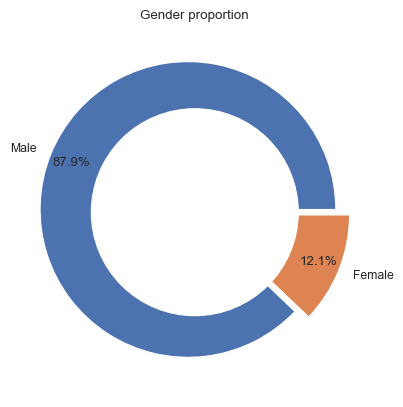

In [3]:
## Gender Proportion
df_gender=pd.DataFrame(dict(Counter(archies["GENDER"])).items(),
                              columns=["Gender","Frequency"])

# explosion
explode = (0.05, 0.05)
  
# Pie Chart
plt.pie(df_gender[~df_gender.Gender.isnull()]['Frequency'], labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.85,
        explode=explode)
  
# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion')
  
# Displaying Chart
plt.show()

### Male and female distribution of sitters for winning Archibald portraits
Beyond the winning painter, we also assess the gender distribution of the sitters within the winning portraits Again we use a donut chart to explore the distribution. According data collected from various online sources, we found that 82% of sitters were recorded as Male, and 18% as Female.

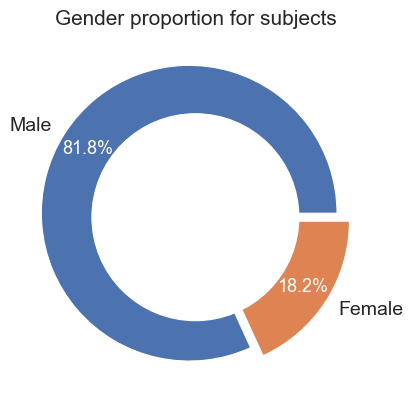

In [4]:
## Gender Proportion
df_gender=pd.DataFrame(dict(Counter(archies["PORTRAIT_GENDER"])).items(),
                              columns=["Gender","Frequency"])

# explosion
explode = (0.05, 0.05)

# Pie Chart
patches, texts, autotexts = plt.pie(df_gender[~df_gender.Gender.isnull()]['Frequency'], labels=['Male','Female'],
        autopct='%1.1f%%', pctdistance=0.815, #textprops={'color':"w", 'fontsize':13},
        explode=explode)

texts[0].set_fontsize(14); texts[1].set_fontsize(14)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(13)

# draw circle
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
  
# Adding Circle in Pie chart
fig.gca().add_artist(centre_circle)
  
# Adding Title of chart
plt.title('Gender proportion for subjects', fontsize=15)
  
# Displaying Chart
plt.show()

### Do males paint males?
We also consider the gender distribution of sitters by male and female Archibald winners. The clustered bar chart shows that 86% of winning portraits painted by males consisted of male sitters. This differs quite a bit to winning portraits painted by females, which consists of an even distribution (50% male sitters, 50% female sitters). It should be noted that there are 12 winning portraits painted by females.

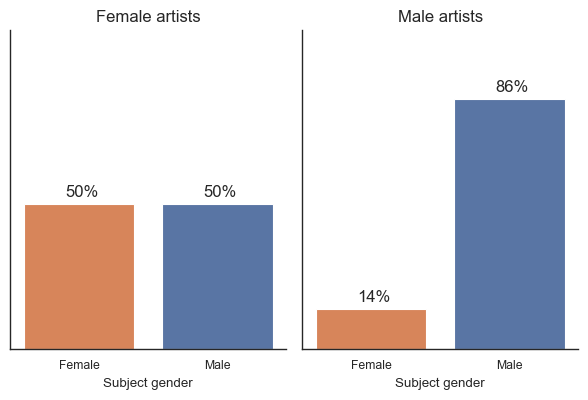

In [5]:
# create a crosstab table
df_crosstab = pd.crosstab(index=archies['GENDER'], columns=archies['PORTRAIT_GENDER'], normalize='index')

# convert the crosstab table to a tidy format
df_tidy = pd.crosstab(archies['GENDER'], archies['PORTRAIT_GENDER'], normalize='index').stack().reset_index()
df_tidy.columns = ['Artist Gender', 'Subject gender', 'Proportion']

g = sns.FacetGrid(df_tidy, col="Artist Gender")
g.map(sns.barplot, "Subject gender", "Proportion", order=["Female", "Male"], palette=['#EC7E45', '#4C72B0'])

g.set_titles(
    col_template="{col_name} artists",
    size=12,
)

# change y-axis limits
g.set(ylim=(0, 1.1))

# remove y-axis ticks and labels
g.set(yticks=[])
g.set(yticklabels=[])
g.set(ylabel=None)

# For each bar, add the label with rounded value
for ax in g.axes.flat:
    for p in ax.patches:
        ax.annotate('{:.0%}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+0.025), size=12)

# increase figure size'
g.fig.set_figwidth(6.5)
g.fig.set_figheight(4.5)

plt.show()

### Male and female distribution over time 
The two time series visualisations below showcase the number of Archibald winners and sitters across twenty-year brackets. The data for Archibald winners reveals that only in recent decades have females won a higher proportion of Archibald prizes in comparison to their corresponding vicennium. The trend for sitters also shares a similar pattern to the Archibald winners time series. Following our previous insights, this suggests that as more female artists win Archibalds, there is a corresponding increase in the number of female sitters being painted.

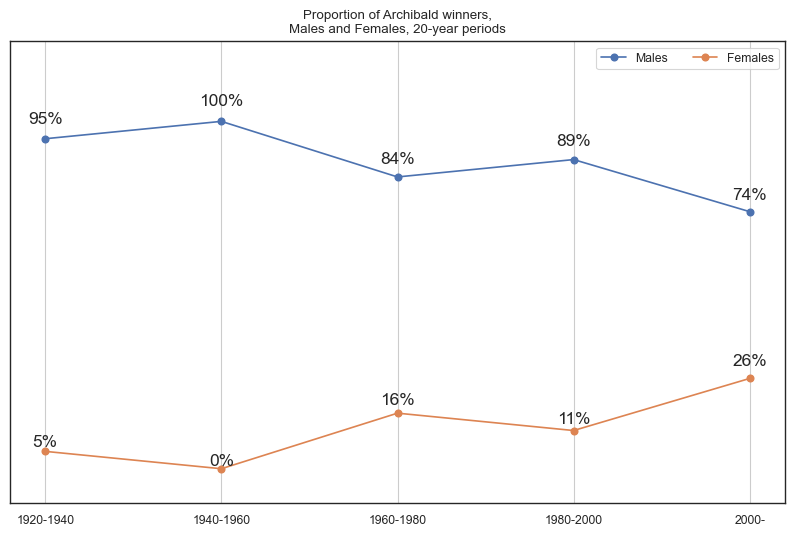

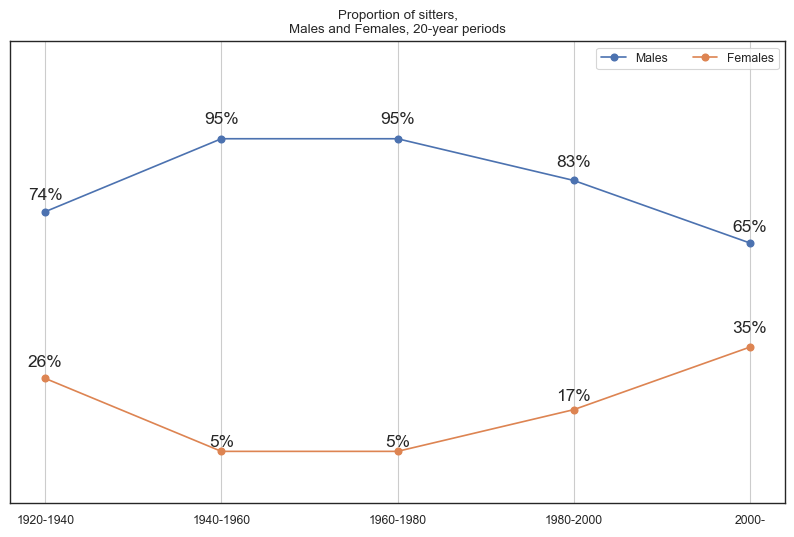

In [6]:
### create a new column for the year of the vicennium
archies['year_vicennium'] = [ int(np.floor(int(year)/20) * 20) 
                            for year in np.array(archies['YEAR'])]

archies['year_vicennium'] = np.where(archies['year_vicennium'] == 2020, 2000, archies['year_vicennium'])

### get count by gender
males_tab = archies[archies['GENDER'] == 'Male']['year_vicennium']\
.value_counts()\
.reset_index()\
.sort_values('index')

females_tab = archies[archies['GENDER'] == 'Female']['year_vicennium']\
.value_counts()\
.reset_index()\
.sort_values('index')

males_sitters_tab = archies[archies['PORTRAIT_GENDER'] == 'Male']['year_vicennium']\
.value_counts()\
.reset_index()\
.sort_values('index')

females_sitters_tab = archies[archies['PORTRAIT_GENDER'] == 'Female']['year_vicennium']\
.value_counts()\
.reset_index()\
.sort_values('index')

### merge tables and get row proportions for Males and Females
count_by_gender = pd.merge(males_tab, females_tab, on='index', how='outer').fillna(0)
count_by_gender.columns = ['Vicennium', 'Males', 'Females']
count_by_gender['Females_Prop'] = round(count_by_gender['Females']/(count_by_gender['Females'] + count_by_gender['Males']),2)
count_by_gender['Males_Prop'] = round(count_by_gender['Males']/(count_by_gender['Females'] + count_by_gender['Males']),2)

count_by_gender_sitter = pd.merge(males_sitters_tab, females_sitters_tab, on='index', how='outer').fillna(0)
count_by_gender_sitter.columns = ['Vicennium', 'Males', 'Females']
count_by_gender_sitter['Females_Prop'] = round(count_by_gender_sitter['Females']/(count_by_gender_sitter['Females'] + count_by_gender_sitter['Males']),2)
count_by_gender_sitter['Males_Prop'] = round(count_by_gender_sitter['Males']/(count_by_gender_sitter['Females'] + count_by_gender_sitter['Males']),2)

### plot gender proportions of winners over time
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(count_by_gender['Vicennium'], 
        count_by_gender['Males_Prop'], 
        label="Males", marker='o')
plt.plot(count_by_gender['Vicennium'], 
        count_by_gender['Females_Prop'], 
        label="Females", marker='o')

for i, txt in enumerate(count_by_gender['Males_Prop']):
    ax.annotate(str(int(round(txt*100,0)))+ '%', (count_by_gender['Vicennium'][i], 
                     count_by_gender['Males_Prop'][i]*1.035), 
                ha='center', va='bottom', size=12.5)

for i, txt in enumerate(count_by_gender['Females_Prop']):
    ax.annotate(str(int(round(txt*100,0)))+ '%', (count_by_gender['Vicennium'][i], 
                     count_by_gender['Females_Prop'][i]*1.1), 
                ha='center', va='bottom', size=12.5)

# adjust legend
ax.legend(loc="upper right", ncol=2)

ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks([])
plt.xlabel('')
plt.ylim([-0.1, 1.23])
plt.grid(axis='x')
plt.xticks([1920,1940,1960,1980,2000], ['1920-1940', '1940-1960', '1960-1980','1980-2000', '2000-'])
plt.title('Proportion of Archibald winners,\nMales and Females, 20-year periods')
plt.show()

### plot gender proportions of sitters over time
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(count_by_gender_sitter['Vicennium'], 
        count_by_gender_sitter['Males_Prop'], 
        label="Males", marker='o')
plt.plot(count_by_gender_sitter['Vicennium'], 
        count_by_gender_sitter['Females_Prop'], 
        label="Females", marker='o')

for i, txt in enumerate(count_by_gender_sitter['Males_Prop']):
    ax.annotate(str(int(round(txt*100,0)))+ '%', (count_by_gender_sitter['Vicennium'][i], 
                     count_by_gender_sitter['Males_Prop'][i]*1.035), 
                ha='center', va='bottom', size=12.5)

for i, txt in enumerate(count_by_gender_sitter['Females_Prop']):
    ax.annotate(str(int(round(txt*100,0)))+ '%', (count_by_gender_sitter['Vicennium'][i], 
                     count_by_gender_sitter['Females_Prop'][i]*1.09), 
                ha='center', va='bottom', size=12.5)

# adjust legend
ax.legend(loc="upper right", ncol=2)

ax.yaxis.set_ticklabels([])
ax.yaxis.set_ticks([])
plt.xlabel('')
plt.ylim([-0.1, 1.23])
plt.grid(axis='x')
plt.xticks([1920,1940,1960,1980,2000], ['1920-1940', '1940-1960', '1960-1980','1980-2000', '2000-'])
plt.title('Proportion of sitters,\nMales and Females, 20-year periods')
plt.show()

### Winning age for Archibald winners
We use a histogram chart to explore the distribution of winning age. The histogram exhibits a relatively bi-modal shape with some painters winning the Archibald prize much later in their career. However, the majority cluster around the mid-40s.

The youngest painter to win the Archibald Prize was Nora Heysen at the age of 27 years (1938) and the oldest being John Olsen wininng at the age of 77 years (2005).

Furthermore, we calculate the median winning age by gender of winning painter, and found that males (45) on average win later than females (39).

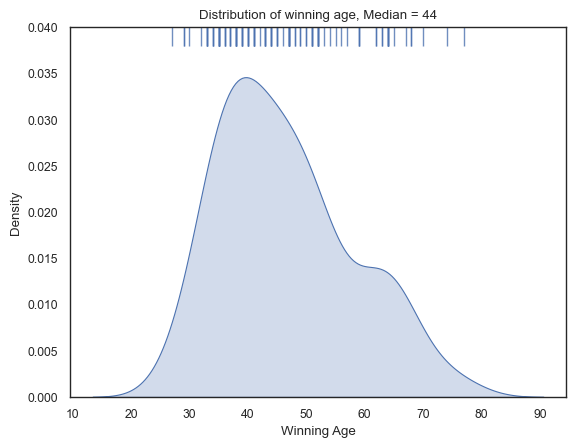

In [7]:
def upper_rugplot(data, height=.05, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    ax = ax or plt.gca()
    kwargs.setdefault("linewidth", 1)
    segs = np.stack((np.c_[data, data],
                     np.c_[np.ones_like(data), np.ones_like(data)-height]),
                    axis=-1)
    lc = LineCollection(segs, transform=ax.get_xaxis_transform(), **kwargs)
    ax.add_collection(lc)

archies['winning_age'] = archies['YEAR'] - archies['DOB']
sns.kdeplot(archies['winning_age'], fill=True)
upper_rugplot(archies['winning_age'], height=.05, alpha=.8)

plt.title('Distribution of winning age, Median = 44')
plt.ylim([0, 0.04])
plt.xlabel('Winning Age')
plt.show()

### Winning age by year
The first line plot below shows the age of Archibald winners per year. At first glance, the winning age appears to fluctuate randomly, but there are some observable patterns prior to 1960. Upon closer examination, we discover that these gradual changes are the result of the same individuals winning the Archibald Prize multiple times. 

We list five of the most frequent Archibald winners - all of which have more than three prizes.

| Artist | Number of Archibald prizes |
| :- | -: |
| William Dargie | 8 |
| W B McInnes | 7 |
| John Longstaff | 5 |
| Ivor Hele | 5 |
| William Pidgeon | 4 |

The second line plot emphasises on these five artists, highlighting some interesting insights. 
- The first 41 years of the Archibald prize were dominated by these multi-winners, specifcally winning more than two thirds (68.3%) of Archibald wins
- W B McInnes and John Longstaff dominated the 1920-1940 period, collectively winning 12 out 19 Archibalds
- William Dargie and Ivor Hele dominated the 1940-1960 period, collectively winning 13 out 20 Archibalds
- We see a lot more distribution amongst painters in recent decades, with less occurence of repeat winners.

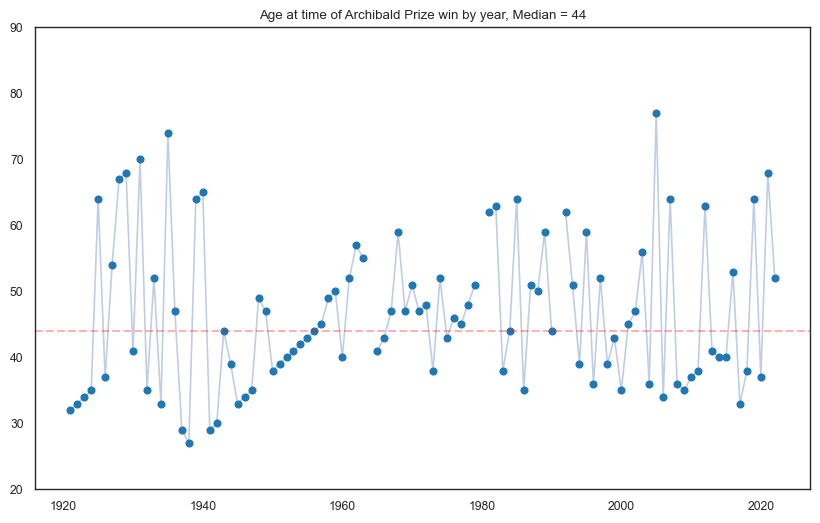

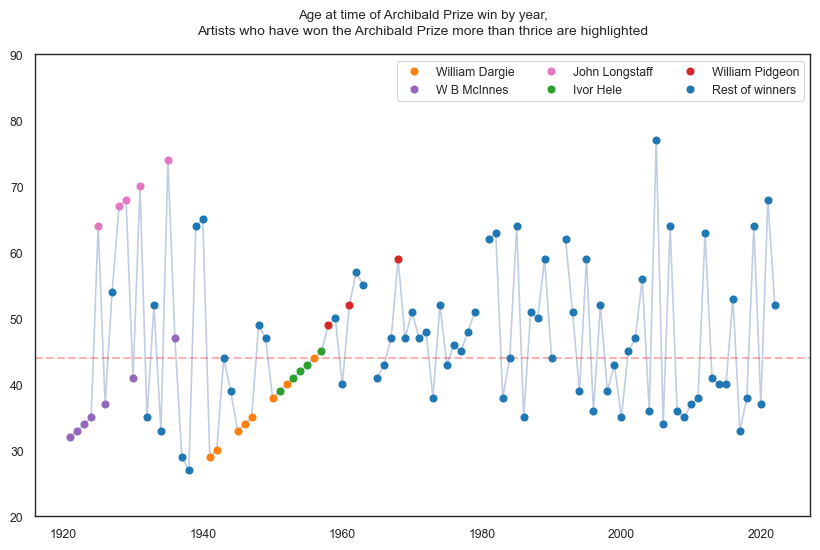

In [8]:
### plot winning age by year
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(archies['YEAR'], archies['winning_age'], alpha=0.35)
plt.plot(archies['YEAR'], archies['winning_age'], 
marker='o', linestyle='', color='tab:blue')

plt.axhline(y=44, color='red', linestyle='--', lw=1.5, alpha=0.3)

plt.ylim([20, 90])
plt.title('Age at time of Archibald Prize win by year, Median = 44')
plt.show()

############################################

### plot winning age by year and highlight multi-winners
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(archies['YEAR'], archies['winning_age'], alpha=0.35)
plt.axhline(y=44, color='red', linestyle='--', lw=1.5, alpha=0.3)

### William Dargie
cond = (archies['WINNER'] == 'William Dargie')
plt.plot(archies[cond]['YEAR'], archies[cond]['winning_age'], 
marker='o', linestyle='', color='tab:orange', label='William Dargie')

### W B McInnes
cond2 = (archies['WINNER'] == 'W B McInnes')
plt.plot(archies[cond2]['YEAR'], archies[cond2]['winning_age'], 
marker='o', linestyle='', color='tab:purple', label='W B McInnes')

### John Longstaff
cond3 = (archies['WINNER'] == 'John Longstaff')
plt.plot(archies[cond3]['YEAR'], archies[cond3]['winning_age'], 
marker='o', linestyle='', color='tab:pink', label='John Longstaff')

### Ivor Hele
cond4 = (archies['WINNER'] == 'Ivor Hele')
plt.plot(archies[cond4]['YEAR'], archies[cond4]['winning_age'], 
marker='o', linestyle='', color='tab:green', label='Ivor Hele')

### William Pidgeon
cond5 = (archies['WINNER'] == 'William Pidgeon')
plt.plot(archies[cond5]['YEAR'], archies[cond5]['winning_age'], 
marker='o', linestyle='', color='tab:red', label='William Pidgeon')

cond_rest = (archies['WINNER'] != 'William Dargie') & (archies['WINNER'] != 'W B McInnes') & \
    (archies['WINNER'] != 'John Longstaff') & (archies['WINNER'] != 'Ivor Hele') & \
    (archies['WINNER'] != 'William Pidgeon')
plt.plot(archies[cond_rest]['YEAR'], archies[cond_rest]['winning_age'], 
marker='o', linestyle='', color='tab:blue', label='Rest of winners')

# adjust legend
ax.legend(loc="upper right", ncol=3)
plt.title('Age at time of Archibald Prize win by year,\n\n')

# add subtitle
plt.text(0.5, 1.05, 'Artists who have won the Archibald Prize more than thrice are highlighted', 
horizontalalignment='center', verticalalignment='center', 
transform=ax.transAxes, fontsize=10)

plt.ylim([20, 90])
plt.show()

### Winning age for Archibald winners (cont.)
To consider multi-winners, we assess the average winning age at different milestones in relation to the Archibald Prize (1st win, 2nd winm, etc.). The bar plot shows a similar average (43.5) for first-time winners (highlighted in orange) when compared with the overall median (44). This is likely due to the fact that most artists have only won the prize once (62 artists).

When considering second wins, the average winning age increases to 48.5, but then decreases for subsequent wins. This pattern may be a result of small sample sizes, but also suggests that multi-winners tend to experience early success. The only exception is John Longstaff, who won all his prizes after the age of 64.

Interestingly, William Dargie, who won his eighth and final Archibald Prize, was 44 years old, which is the same as the overall median winning age.

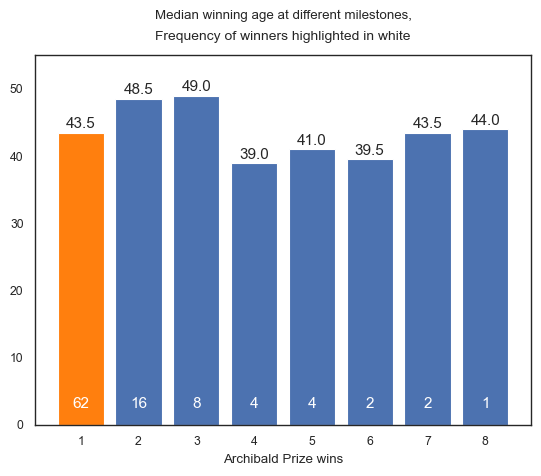

In [9]:
### plot winning age at different milestones
archies['count'] = 0

# create count for each artist
winner_count_dict = dict()
for idx,row in archies.sort_values('YEAR')['WINNER'].items():
    if row not in winner_count_dict:
        archies.loc[idx,'count'] = 1
        winner_count_dict[row] = 1
    else:
        winner_count_dict[row] = winner_count_dict[row] + 1
        archies.loc[idx,'count'] = winner_count_dict[row]
        
x = [1,2,3,4,5,6,7,8]
y = [
    archies[archies['count'] == 1]['winning_age'].median(),
    archies[archies['count'] == 2]['winning_age'].median(),
    archies[archies['count'] == 3]['winning_age'].median(),
    archies[archies['count'] == 4]['winning_age'].median(),
    archies[archies['count'] == 5]['winning_age'].median(),
    archies[archies['count'] == 6]['winning_age'].median(),
    archies[archies['count'] == 7]['winning_age'].median(),
    archies[archies['count'] == 8]['winning_age'].median()
    ]

fig, ax = plt.subplots()
ax.bar(x, y)
ax.bar(x[0], y[0], color='tab:orange')
ax.set_xlabel('Archibald Prize wins')
ax.set_title('Median winning age at different milestones,\n\n')

# add subtitle
plt.text(0.5, 1.05, 'Frequency of winners highlighted in white', 
horizontalalignment='center', verticalalignment='center', 
transform=ax.transAxes, fontsize=10)

plt.ylim([0, 55])

omit_nowins = (~archies.winning_age.isnull())

for i, v in enumerate(y): 
    ax.annotate(str(v), (i+1,v*1.005), ha='center', va='bottom', size=11)
    ax.annotate(archies[(archies['count'] == i+1) & omit_nowins].shape[0], 
    (i+1,2), ha='center', va='bottom', size=11, color='white')

plt.show()

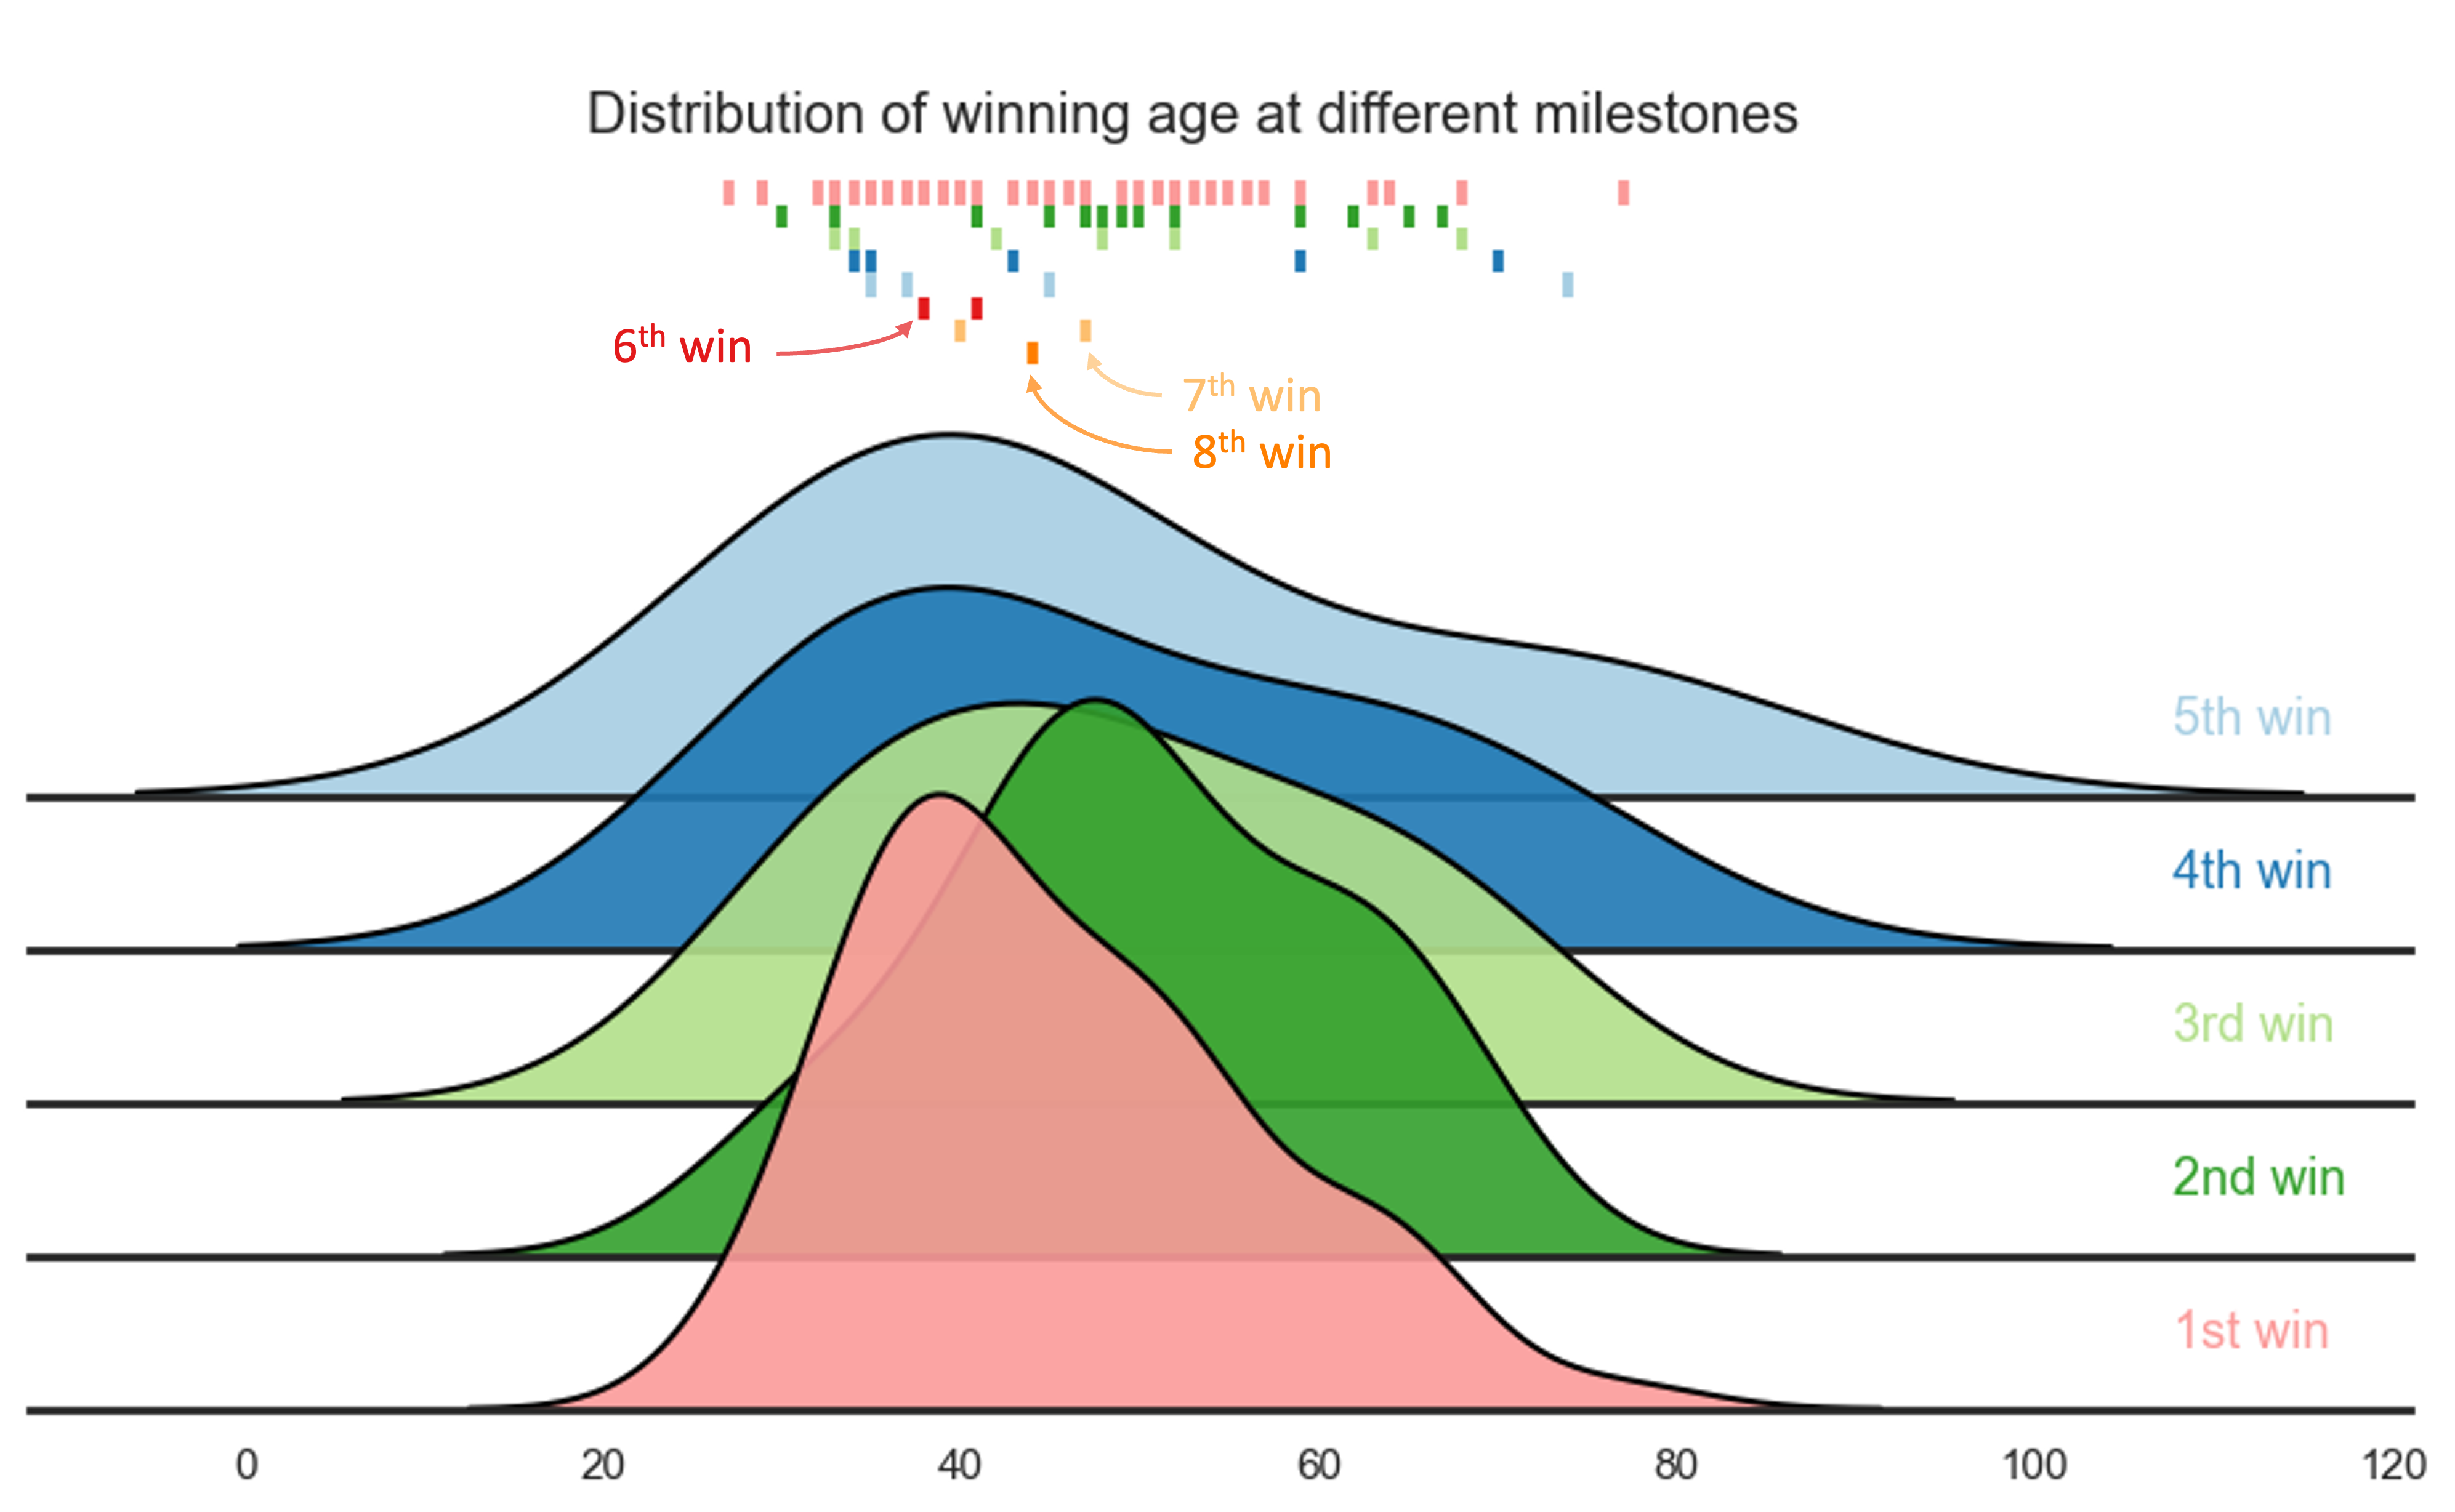

In [10]:
# def upper_rugplot(data, height=.05, ax=None, **kwargs):
#     from matplotlib.collections import LineCollection
#     ax = ax or plt.gca()
#     kwargs.setdefault("linewidth", 1)
#     segs = np.stack((np.c_[data, data],
#                      np.c_[np.ones_like(data), np.ones_like(data)-height]),
#                     axis=-1)
#     lc = LineCollection(segs, transform=ax.get_xaxis_transform(), **kwargs)
#     ax.add_collection(lc)

# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})  
# palette = sns.color_palette("Paired", 8)    
# archies_density = archies[archies['count'] < 9].copy()  
# archies_density['count_verbose'] = np.where(archies_density['count'] == 1, '1st win', np.nan)  
# archies_density['count_verbose'] = np.where(archies_density['count'] == 2, '2nd win', archies_density['count_verbose'])  
# archies_density['count_verbose'] = np.where(archies_density['count'] == 3, '3rd win', archies_density['count_verbose'])  
# archies_density['count_verbose'] = np.where(archies_density['count'] == 4, '4th win', archies_density['count_verbose'])  
# archies_density['count_verbose'] = np.where(archies_density['count'] == 5, '5th win', archies_density['count_verbose'])  
# archies_density['count_verbose'] = pd.Categorical(archies_density['count_verbose'],   
# categories=['5th win','4th win','3rd win','2nd win','1st win'], ordered=True)    
# g = sns.FacetGrid(archies_density, palette=palette, row="count_verbose", hue="count_verbose", aspect=8, height=1.2)  
# g.map_dataframe(sns.kdeplot, x="winning_age", fill=True, alpha=0.9)  
# g.map_dataframe(sns.kdeplot, x="winning_age", color='black')    
# upper_rugplot(archies_density[archies_density['count'] == 8]['winning_age'], color=palette[7], linewidth=2.75, height=0.24, ax=g.axes[1,0])
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.21, ax=g.axes[1,0])  
# upper_rugplot(archies_density[archies_density['count'] == 7]['winning_age'], color=palette[6], linewidth=2.75, height=0.21, ax=g.axes[1,0])
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.18, ax=g.axes[1,0]) 
# upper_rugplot(archies_density[archies_density['count'] == 6]['winning_age'], color=palette[5], linewidth=2.75, height=0.18, ax=g.axes[1,0])
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.15, ax=g.axes[1,0]) 
# upper_rugplot(archies_density[archies_density['count'] == 5]['winning_age'], color=palette[0], linewidth=2.75, height=0.15, ax=g.axes[1,0])  
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.12, ax=g.axes[1,0])  
# upper_rugplot(archies_density[archies_density['count'] == 4]['winning_age'], color=palette[1], linewidth=2.75, height=.12, ax=g.axes[1,0])  
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.09, ax=g.axes[1,0])  
# upper_rugplot(archies_density[archies_density['count'] == 3]['winning_age'], color=palette[2], linewidth=2.75, height=.09, ax=g.axes[1,0])  
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.06, ax=g.axes[1,0])  
# upper_rugplot(archies_density[archies_density['count'] == 2]['winning_age'], color=palette[3], linewidth=2.75, height=.06, ax=g.axes[1,0])  
# upper_rugplot(range(25,85), color='white', linewidth=3, height=.03, ax=g.axes[1,0])  
# upper_rugplot(archies_density[archies_density['count'] == 1]['winning_age'], color=palette[4], linewidth=2.75, height=.03, ax=g.axes[1,0])    

# def label(x, color, label):      
#     ax = plt.gca()      
#     ax.text(0.9, .1, label, color=color, fontsize=13,      
#     ha="left", va="center", transform=ax.transAxes)    
    
# g.map(label, "count_verbose")  
# g.fig.subplots_adjust(hspace=-0.8)  
# g.set_titles("")  
# g.set(yticks=[], xlabel="", ylabel="", ylim=[0, 0.045])  
# g.despine( left=True)    
# plt.suptitle('Distribution of winning age at different milestones', x=0.52, y=0.9)  
# plt.show()

# majority of the below visualisation was constucted in python
# however, extra editing was done outside of python to get the final image
from IPython.display import Image
Image(filename='images/images_analysis/StackedDensity.png', width=800)

```{epigraph}
By the time the average participant achieves their first Archibald Prize, William Dargie had already secured his eighth Archibald win.
```

### Winning age for Archibald winners by vicennium
By analysing the winning age data by milestone and decade, we can observe that the average winning age for first-time winners has experienced fluctuations over time. During the 1920-1940 period, the median winning age for first-time winners was 35. However, this average rose to 46.5 over the next forty years and then dropped back to 40 in the 2000s. A similar pattern was observed for second-time winners, with a peak median of 60.5 in the 1980-2000 period.

As illustrated in previous visualisations, third-time winners and beyond tend to occur more often in earlier decades. The last artist to win three Archibald prizes was Eric John Smith in 1982 at the age of 63.

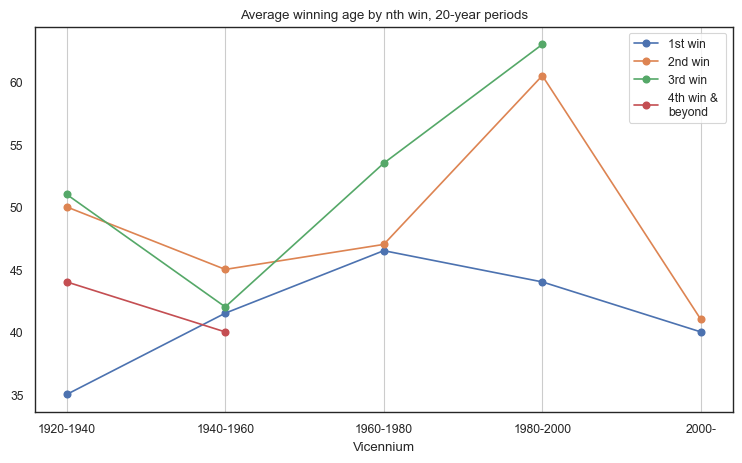

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))

### groupby mean age of winners by vicennium
archies[archies['count'] == 1].groupby('year_vicennium')['winning_age'].median().reset_index().\
    plot(x='year_vicennium', y='winning_age', marker='o', ax=ax, label='1st win')
archies[archies['count'] == 2].groupby('year_vicennium')['winning_age'].median().reset_index().\
    plot(x='year_vicennium', y='winning_age', marker='o',ax=ax, label='2nd win')
archies[archies['count'] == 3].groupby('year_vicennium')['winning_age'].median().reset_index().\
    plot(x='year_vicennium', y='winning_age', marker='o',ax=ax, label='3rd win')
archies[archies['count'] > 3].groupby('year_vicennium')['winning_age'].median().reset_index().\
    plot(x='year_vicennium', y='winning_age', marker='o',ax=ax, label='4th win & \nbeyond')

ax.set(xlabel="Vicennium", ylabel="")
plt.grid(axis='x')
plt.xticks([1920,1940,1960,1980,2000], 
['1920-1940', '1940-1960', '1960-1980','1980-2000', '2000-'])

# plt.title('Average winning age by $\it{n}$th win, 20-year periods')
plt.title('Average winning age by nth win, 20-year periods')

# add legend 2 by 2
plt.legend(facecolor='white', loc='upper right', ncol=1)

plt.show()

## Colour and Brightness
The below visualisations explore the colour and brightness of winning Archibald portraits. We first discuss our methodology of colour extraction and colour averaging before exploring the results.

### Colour averaging
An image can be summarised down into one average color by taking the average color of all pixels in the image.
- Each pixel in an image is represented by a combination of three color values: red, green, and blue (RGB). 
- The range of each value is usually from 0 to 255, representing the intensity of the color.

To compute the average color of an image, the RGB values of each pixel are first extracted and then averaged across all pixels in the image. The resulting values represent the average color of the image.

**Example:**
An image is often represented as a two-dimensional array of numbers, where each number represents the intensity or color of a pixel. The size of the array corresponds to the dimensions of the image, and each element in the array corresponds to a pixel in the image.

For example, consider a simple grayscale image of size 4x4 pixels:

|    |  0 |  1 |  2 |  3 |
|----|----|----|----|----|
|  0 | 10 | 15 | 20 | 25 |
|  1 | 30 | 35 | 40 | 45 |
|  2 | 50 | 55 | 60 | 65 |
|  3 | 70 | 75 | 80 | 85 |

In this case, the numbers in the array represent the intensity of each pixel, ranging from 0 (black) to 255 (white). For example, the pixel in the top-left corner of the image has an intensity of 10, while the pixel in the bottom-right corner has an intensity of 85.

For a color image, the array would have an extra dimension representing the color channels (usually red, green, and blue), resulting in a three-dimensional array. For example, a color image of size 4x4 pixels might be represented as:

|    |        0         |        1         |        2         |         3         |
|----|-----------------|-----------------|-----------------|------------------|
|  0 | [10, 20, 30]    | [15, 25, 35]    | [20, 30, 40]    | [25, 35, 45]     |
|  1 | [30, 40, 50]    | [35, 45, 55]    | [40, 50, 60]    | [45, 55, 65]     |
|  2 | [50, 60, 70]    | [55, 65, 75]    | [60, 70, 80]    | [65, 75, 85]     |
|  3 | [70, 80, 90]    | [75, 85, 95]    | [80, 90, 100]   | [85, 95, 105]    |

In this case, each pixel is represented by a three-element array, with each element representing the intensity of the red, green, and blue channels, respectively. For example, the pixel in the top-left corner of the image has a red intensity of 10, a green intensity of 20, and a blue intensity of 30.

### Colour over time

We first consider the average colour of winning portraits by decade.

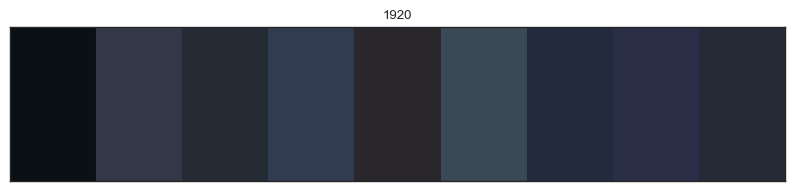

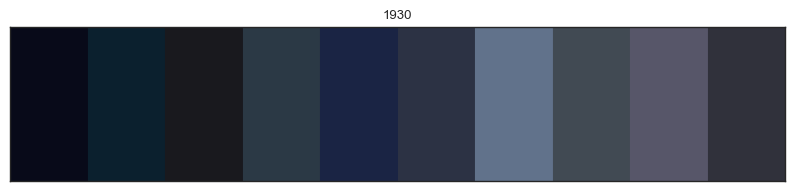

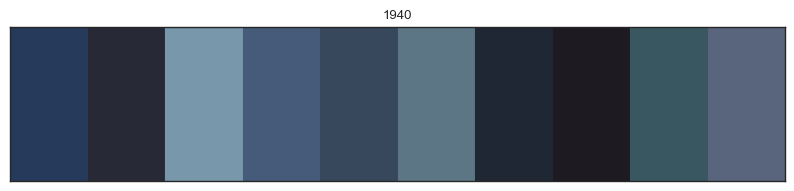

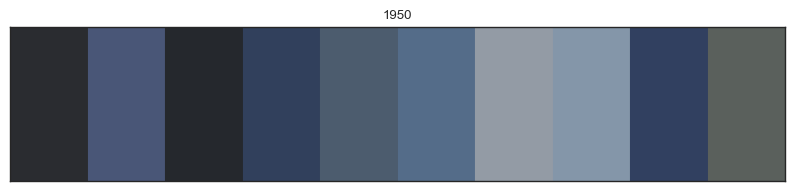

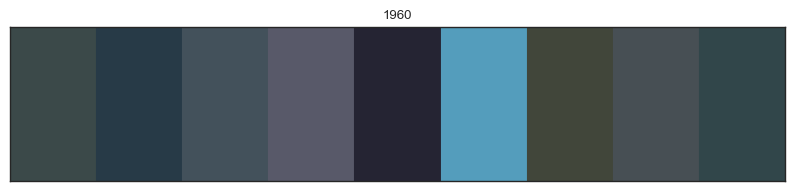

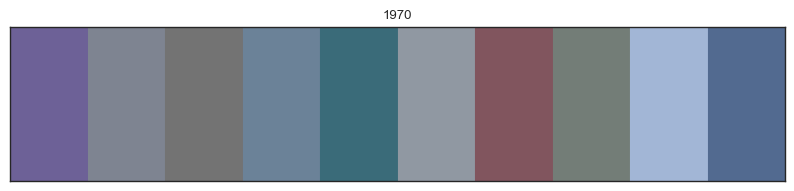

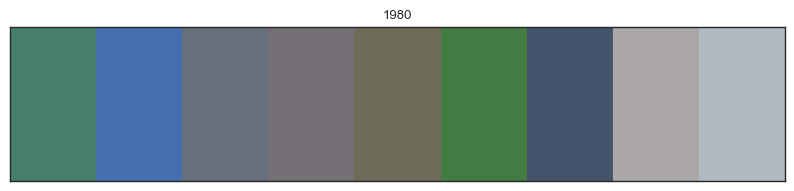

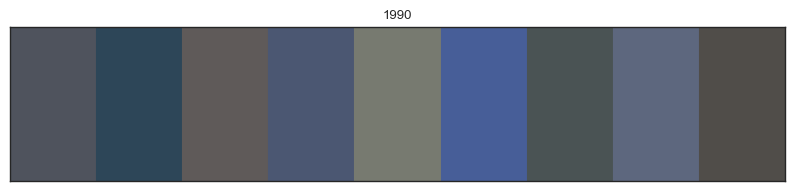

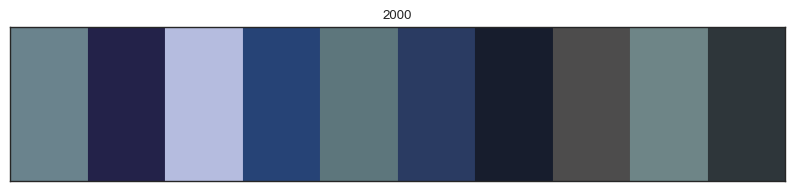

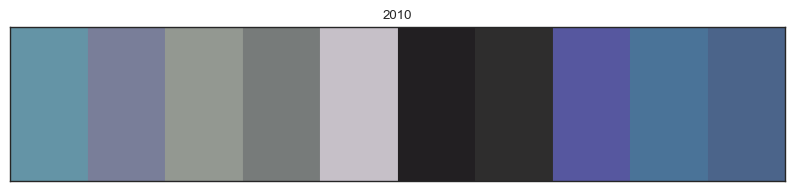

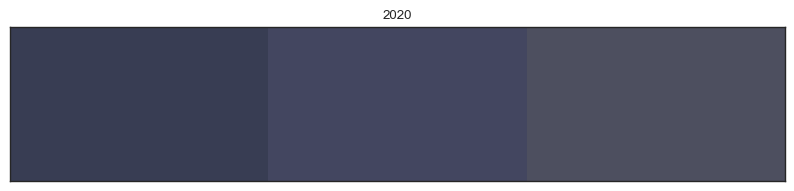

In [12]:
# Fetch colour data for every Archibald winning potrait
def get_avg_color(img):
    # read image from file
    myimg = cv2.imread('./images/images_analysis/ArchibaldWinners/' + img)

    # convert to numpy array
    avg_color_per_row = np.average(myimg, axis=0)

    # average the colors
    avg_color = np.average(avg_color_per_row, axis=0)
    return avg_color

# sort files by name
portraits_path = "./images/images_analysis/ArchibaldWinners"
onlyfiles = [f for f in listdir(portraits_path) if isfile(join(portraits_path, f))]
onlyfiles.sort()

# change to dataframe
of_df = pd.DataFrame(onlyfiles)

# add year column and fix one-off error in 1991
of_df['year'] = of_df[0].apply(lambda x: int(x.split('_')[0]))
of_df.loc[of_df[0] == '1990_SID78808M.jpg.641x900_q85.jpg','year'] = 1991

# add decade column
of_df['decade'] = [ int(np.floor(int(year)/10) * 10) 
                       for year in np.array(of_df["year"])]

# add RGB columns for averaged colour
of_df[['r','g','b']] = of_df[0].apply(lambda x: list(get_avg_color(x))).tolist()

# add HEX column for averaged colour
for x in of_df.sort_values('year').decade.unique():

    # sort by year
    images_df_sorted = of_df[of_df.decade == x].sort_values('year')

    # convert RGB to HEX code
    colors = list(zip(images_df_sorted.r, images_df_sorted.g, images_df_sorted.b))
    scaled_colours = [[color / 255 for color in row] for row in colors]

    # plot colour bars in order by decade
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.axis(xmin=0, xmax=len(scaled_colours))
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    for index, colour in enumerate(scaled_colours): ax.axvspan(index, index + 1, color=colour)

    # add year labels
    plt.title(x)

### Colour averaging and categorisation

The below visualisations were constructed using python code which extracts and categorises colors from each image of the winning portrait. The code begins by importing various libraries, including PIL, OpenCV, and matplotlib, which are used for image manipulation and visualization, as well as external packages like extcolors and colormath for colour extraction and categorisation.

**Step 1**
<br>
The get_closest_color() function is used to determine the closest named colour to a given RGB value using the CIE2000 algorithm, which measures the difference between two colours in terms of their perceived similarity. The colour names and corresponding RGB values are stored in a color_map dictionary, which is created using the webcolors library.

The CIE2000 algorithm is named after the International Commission on Illumination (CIE), an organisation that sets standards for colour measurement and specification. The algorithm takes into account how colours are perceived by the human eye, including factors like brightness, saturation, and hue. It was developed to improve upon earlier colour difference formulas, which were found to be inadequate for accurately describing how colours appear to the human eye.

**Step 2**
<br>
Next, the code reads in a list of image file names from a directory and uses the extcolors library to extract the dominant colours from each image. The extracted colours are then processed using the color_to_df() function to create a dataframe of colour codes, occurrence frequencies, and proportions.

The code then ranks the colours by their proportion and assigns a colour name using the get_closest_color() function and the color_map dictionary. The color_map dictionary is essentially a collection of named colours and their corresponding RGB values. In this code, the color_map dictionary is created using the webcolors library, which provides a list of 147 named colours and their corresponding RGB values in a convenient format. The reason the color_map dictionary is useful is that it allows the code to assign a human-readable name to each colour it extracts from an image. For example, if the code extracts a colour that is very close to (255, 0, 0), it can look up that RGB value in the color_map dictionary and see that it corresponds to the colour name "red." This makes it easier for humans to interpret and analyze the resulting data.

**Step 3**
<br>
Finally, the resulting colour data is concatenated into a single dataframe for further analysis.


*Note we commented out the code for the colour extraction and categorisation process as it takes 3 minutes to run. Instead, we saved the resulting dataframe as a csv file and imported it into the notebook from the ACDE Github repository.*

In [13]:
# # Takes 3 minutes to run

# import matplotlib.patches as patches
# import matplotlib.image as mpimg

# from PIL import Image
# from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# # !pip install easydev                 #version 0.12.0
# # !pip install colormap                #version 1.0.4
# # !pip install opencv-python           #version 4.5.5.64
# # !pip install colorgram.py            #version 1.2.0
# # !pip install extcolors               #version 1.0.0
# # !pip install colormath               #version 3.0.0
# # !pip install webcolors               #version 1.11.1

# import cv2
# import extcolors

# from colormap import rgb2hex
# from colormath.color_objects import sRGBColor, LabColor
# from colormath.color_conversions import convert_color
# from colormath.color_diff import delta_e_cie2000
# import webcolors

# def get_closest_color(requested_color, color_map):
#     requested_color = sRGBColor(*requested_color)
#     requested_color = convert_color(requested_color, LabColor)

#     min_distance = float("inf")
#     closest_color = None
#     for color_name, color_rgb in color_map.items():
#         color = sRGBColor(*color_rgb)
#         color = convert_color(color, LabColor)
#         distance = delta_e_cie2000(requested_color, color)
#         if distance < min_distance:
#             min_distance = distance
#             closest_color = color_name

#     return closest_color

# color_map = {color_name: webcolors.name_to_rgb(color_name) for color_name in webcolors.CSS3_NAMES_TO_HEX.keys()}

# from os import listdir
# from os.path import isfile, join
# onlyfiles = [f for f in listdir('./images/ArchibaldWinners') if isfile(join('./images/ArchibaldWinners', f))]

# def color_to_df(input):
#     colors_pre_list = str(input).replace('([(','').split(', (')[0:-1]
#     df_rgb = [i.split('), ')[0] + ')' for i in colors_pre_list]
#     df_percent = [i.split('), ')[1].replace(')','') for i in colors_pre_list]
    
#     #convert RGB to HEX code
#     df_color_up = [rgb2hex(int(i.split(", ")[0].replace("(","")),
#                           int(i.split(", ")[1]),
#                           int(i.split(", ")[2].replace(")",""))) for i in df_rgb]
    
#     df = pd.DataFrame(zip(df_color_up, df_percent), columns = ['c_code','occurence'])
#     return df

# df_colors = pd.DataFrame(columns = ['c_code','occurence'])
# onlyfiles.sort()

# for f in onlyfiles:
#     colors_x = extcolors.extract_from_path('./images/ArchibaldWinners/' + f, 
#                                            tolerance = 12, limit = 25)
#     df_color = color_to_df(colors_x)
#     df_color['proportion'] = df_color['occurence'].astype(float) / df_color['occurence'].astype(float).sum()
#     df_color['rank'] = df_color['proportion'].rank(ascending=False)
#     df_color['color_name'] = df_color.c_code.\
#         apply(lambda x: get_closest_color(webcolors.hex_to_rgb(x), color_map))
#     df_color['year'] = f[:4]
#     # df_colors = df_colors.append(df_color, ignore_index=True)
#     df_colors = pd.concat([df_colors, df_color], ignore_index=True)

# df_colors.to_csv('data/local/archies_colors.csv', index=False)          

# From github, fetch colour data for every Archibald winning potrait
# fetch data from github
df_colors = fetch_small_data_from_github("archies_colors.csv")

# display data
show(df_colors, scrollY="400px", scrollCollapse=True, scrollX=True,
     paging=False, showIndex=False, column_filters="footer", dom="tpr")

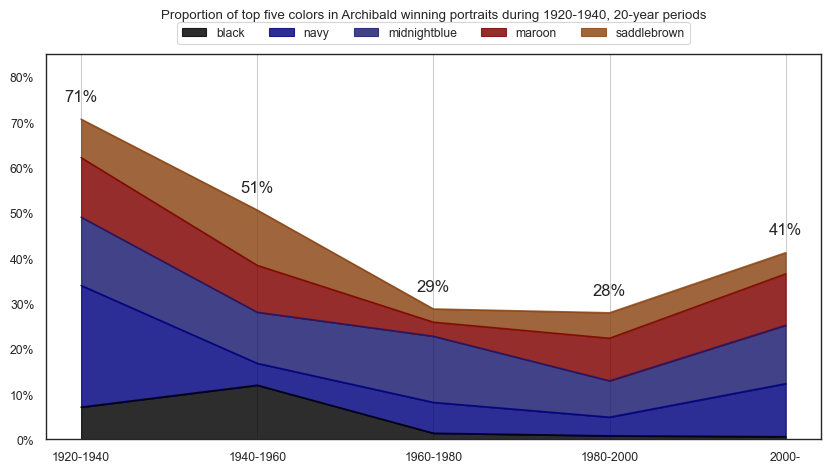

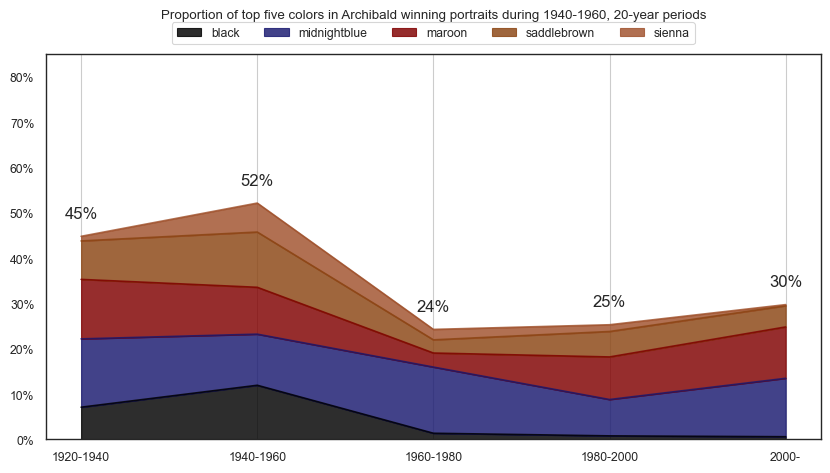

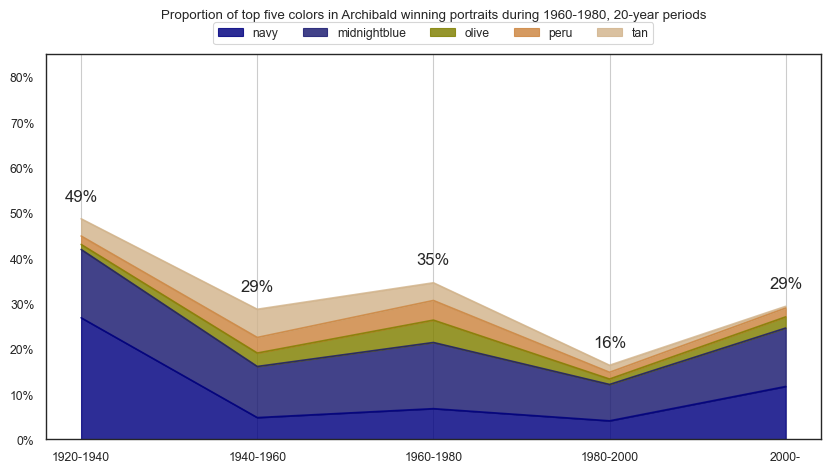

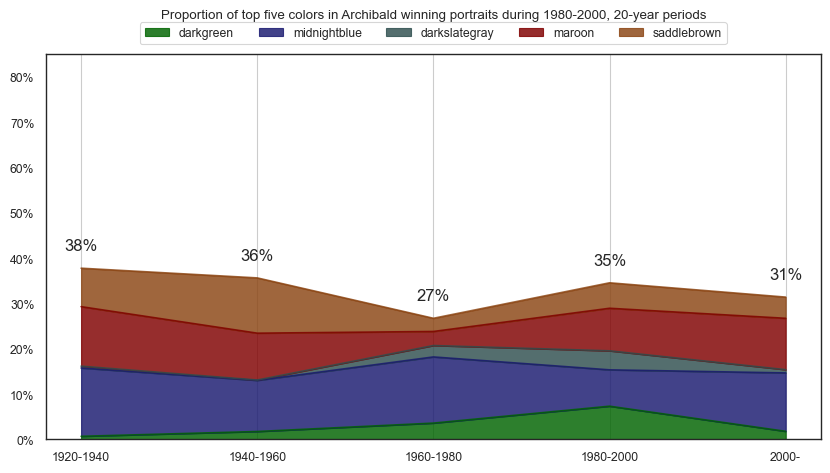

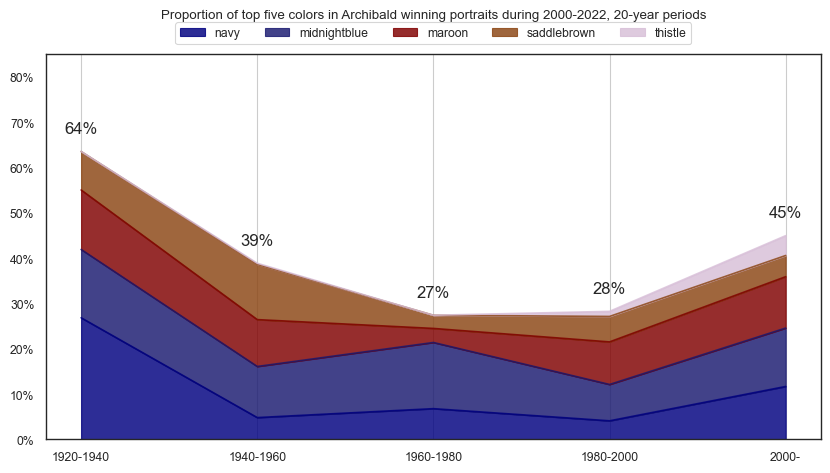

In [14]:
# create a new column for the year in 10 year intervals
df_colors['year_vicennium'] = df_colors['year'].astype(int).apply(lambda x: x - x % 20)
df_colors['year_vicennium'] = np.where(df_colors['year_vicennium'] == 2020, 2000, df_colors['year_vicennium'])

# create a new column for the proportion of colors in each year
len_20_cols = df_colors[df_colors['year_vicennium'] == 1920]['year'].nunique()
len_40_cols = df_colors[df_colors['year_vicennium'] == 1940]['year'].nunique()
len_60_cols = df_colors[df_colors['year_vicennium'] == 1960]['year'].nunique()
len_80_cols = df_colors[df_colors['year_vicennium'] == 1980]['year'].nunique()
len_00_cols = df_colors[df_colors['year_vicennium'] == 2000]['year'].nunique()
df_colors['proportion2'] = np.where(df_colors['year_vicennium'] == 1920, df_colors['proportion']/len_20_cols, np.nan)
df_colors['proportion2'] = np.where(df_colors['year_vicennium'] == 1940, df_colors['proportion']/len_40_cols, df_colors['proportion2'])
df_colors['proportion2'] = np.where(df_colors['year_vicennium'] == 1960, df_colors['proportion']/len_60_cols, df_colors['proportion2'])
df_colors['proportion2'] = np.where(df_colors['year_vicennium'] == 1980, df_colors['proportion']/len_80_cols, df_colors['proportion2'])
df_colors['proportion2'] = np.where(df_colors['year_vicennium'] == 2000, df_colors['proportion']/len_00_cols, df_colors['proportion2'])

for y in df_colors['year_vicennium'].unique():
    # get the top 5 colors for each year
    top5cols = df_colors[df_colors.year_vicennium == y]\
                .groupby(['year_vicennium','color_name'])\
                .agg({'proportion2':'sum'}).reset_index()\
                .sort_values(['year_vicennium','proportion2'], ascending=[True,False])\
                .groupby('year_vicennium')\
                .head(5)['color_name'].unique()

    df_colors_top5 = df_colors[df_colors.color_name.isin(top5cols)]\
                .groupby(['year_vicennium','color_name'])\
                .agg({'proportion2':'sum'}).reset_index()\
                .sort_values(['year_vicennium','proportion2'], ascending=[True,False])\
                .groupby('year_vicennium')\
                .head(5)

    df_colors_top5_pivot = df_colors_top5\
        .pivot(index='year_vicennium', columns='color_name', values='proportion2')\
        .fillna(0)

    # create a new column for the RGB values of each color
    df_colors_top5['red'] = df_colors_top5['color_name']\
        .apply(lambda x: int(CSS3_NAMES_TO_HEX[x][1:3], 16))
    df_colors_top5['green'] = df_colors_top5['color_name']\
        .apply(lambda x: int(CSS3_NAMES_TO_HEX[x][3:5], 16))
    df_colors_top5['blue'] = df_colors_top5['color_name']\
        .apply(lambda x: int(CSS3_NAMES_TO_HEX[x][5:], 16))

    # Define a list of column names to order by
    ordered_columns = df_colors_top5\
        .sort_values(['red','green','blue'], ascending=[True,True,True])['color_name']\
        .unique()

    # Reorder the columns
    df_colors_top5_pivot = df_colors_top5_pivot.reindex(columns=ordered_columns)

    # plot stacked area chart
    df_colors_top5_pivot\
        .plot.area(stacked=True, figsize=(10,5), 
        color=df_colors_top5_pivot.columns, 
        alpha=0.825)

    # add labels for sum of proportions for each year
    for i,x in enumerate(df_colors_top5_pivot.index):
        plt.text(x, df_colors_top5_pivot.iloc[i].sum()+0.05,
        f'{df_colors_top5_pivot.iloc[i].sum():.0%}', 
        ha='center', va='center', fontsize=12)

    plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.1))

    # Set the y-axis limts
    plt.ylim(0, 0.85)

    # Set the y-axis formatter to show percentages
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

    plt.xlabel("")
    plt.grid(axis='x')
    plt.xticks([1920,1940,1960,1980,2000], 
    ['1920-1940', '1940-1960', '1960-1980','1980-2000', '2000-'])

    if y == 2000: plus20 = 2022
    else: plus20 = y + 20
    plt.title(f'Proportion of top five colors in Archibald winning portraits during {y}-{plus20}, 20-year periods\n\n')
    
    
    plt.show()

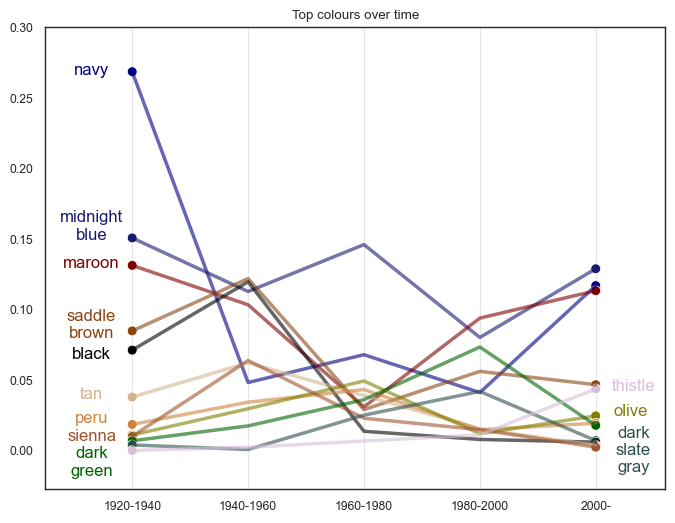

In [15]:
top30cols = df_colors\
            .groupby(['year_vicennium','color_name'])\
            .agg({'proportion2':'sum'}).reset_index()\
            .sort_values(['year_vicennium','proportion2'], ascending=[True,False])\
            .groupby('year_vicennium')\
            .head(5)['color_name'].unique()

top30cols_df = df_colors[df_colors.color_name.isin(top30cols)]\
                .groupby(['year_vicennium','color_name'])\
                .agg({'proportion2':'sum'}).reset_index()\
                .sort_values(['year_vicennium','proportion2'], ascending=[True,False])\
                .groupby('year_vicennium')\
                .head(100)

# plot the top 30 colors for each year as time series
fig, ax = plt.subplots(figsize=(8,6))

# line plot with markers at start and end of each line
sns.lineplot(x='year_vicennium', y='proportion2', hue='color_name', data=top30cols_df,
palette=sns.color_palette(top30cols_df.color_name.unique(), len(top30cols)), ax=ax,
alpha=0.6, linewidth=2.5)

# plot start and end markers
sns.scatterplot(x='year_vicennium', y='proportion2', hue='color_name', 
data=top30cols_df[(top30cols_df.year_vicennium == 1920) | (top30cols_df.year_vicennium == 2000)],
palette=sns.color_palette(top30cols_df.color_name.unique(), len(top30cols)), ax=ax,
s=50, marker='o', legend=False)

# no legend 
ax.legend().remove()
ax.set_title('Top colours over time')
ax.set_xlabel('')
ax.set_ylabel('')

plt.grid(axis='x', alpha=0.5)
plt.ylim(-.0275, 0.3)
plt.xticks([1905, 1920,1940,1960,1980,2000, 2012], 
['','1920-1940', '1940-1960', '1960-1980','1980-2000', '2000-',''])

# add annotation of color_name for each marker
ax.annotate('navy', (1913, 0.257), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='navy')
ax.annotate('midnight\nblue', (1913, 0.14), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='midnightblue')
ax.annotate('maroon', (1913, 0.12), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='maroon')
ax.annotate('saddle\nbrown', (1913, 0.07), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='saddlebrown')
ax.annotate('black', (1913, 0.055), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='black')
ax.annotate('olive', (2006, 0.015), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='olive')
ax.annotate('dark\ngreen', (1913, -0.0275), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='darkgreen')
ax.annotate('peru', (1913, 0.01), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='peru')
ax.annotate('tan', (1913, 0.027), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='tan')
ax.annotate('sienna', (1913, -.0025), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='sienna')
ax.annotate('thistle', (2006.5, 0.0325), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='thistle')
ax.annotate('dark\nslate\ngray', (2006.5, -0.025), textcoords="offset points", xytext=(0,10), ha='center', size=12, color='darkslategray')

# show plot
plt.show()

### Brightness over time

We next consider the average brightness of winning portraits over time.

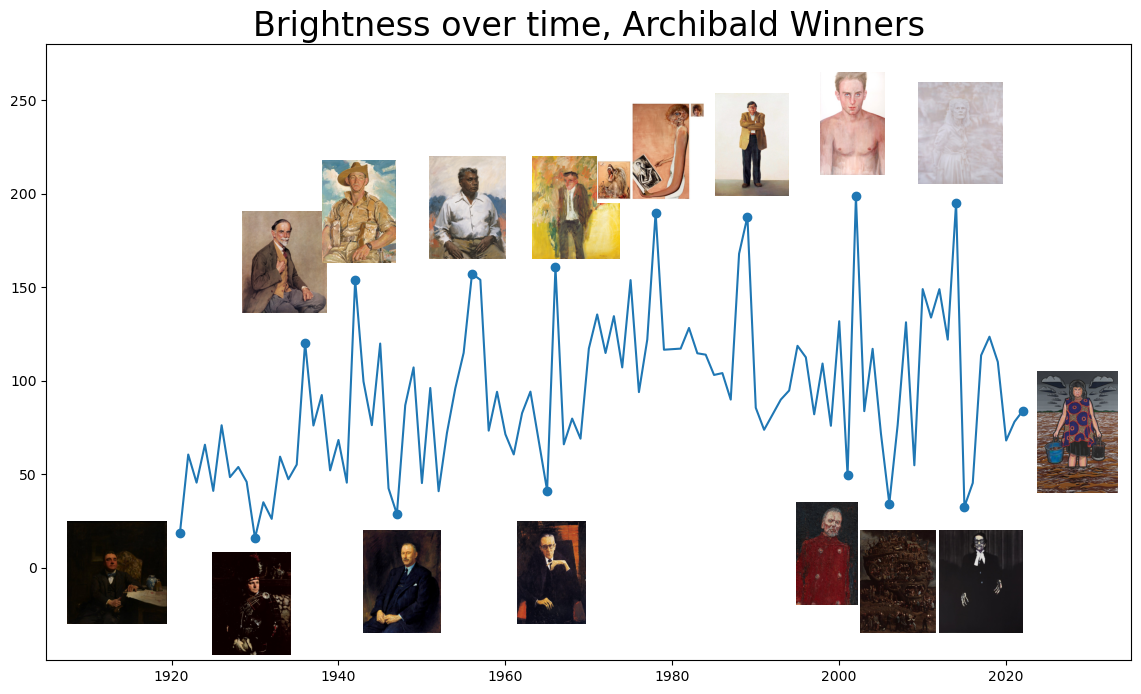

In [16]:
# def brightness( im_file ):
#     im = Image.open(im_file)
#     stat = Stat(im)
#     r,g,b = stat.mean
#     return math.sqrt(0.299*(r**2) + 0.587*(g**2) + 0.114*(b**2))

# portraits_path = "./images/images_analysis/ArchibaldWinners"
# onlyfiles = [f for f in listdir(portraits_path) if isfile(join(portraits_path, f))]

# # sort image files in decade dictionary
# images_df = pd.DataFrame(onlyfiles)
# images_df['year'] = images_df[0].apply(lambda x: int(x.split('_')[0]))
# images_df.loc[images_df[0] == '1990_SID78808M.jpg.641x900_q85.jpg','year'] = 1991
# images_df['decade'] = [ int(np.floor(int(year)/10) * 10) 
#                        for year in np.array(images_df["year"])]
# images_df['brightness'] = images_df[0].apply(lambda x: brightness('./images/images_analysis/ArchibaldWinners/' + x))

# # create figure
# fig = plt.figure(figsize=(14, 8))
# ax = plt.axes()

# peaks = images_df[images_df['year'].isin([1921,1930,1936,1942,1947,1956,
#                                           1965, 1966,1978,1989,
#                                           2001,2002,2006,2014,2015,2022])]

# ax.plot(images_df.sort_values('year')['year'],
#        images_df.sort_values('year')['brightness'])

# ax.plot(peaks.sort_values('year')['year'],
#         peaks.sort_values('year')['brightness'], "o", color='#1f77b4')

# # Draw image
# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1936].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1926,136,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1942].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1935,163,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1956].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1948,165,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/'+ \
#                        images_df[images_df.year == 1966].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1961,165,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1989].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1982,199,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1978].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1970,195,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 2002].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1994,210,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 2014].iloc[0][0], format='jpg')
# axin = ax.inset_axes([2007,205,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1921].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1906,-30,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 2022].iloc[0][0], format='jpg')
# axin = ax.inset_axes([2021,40,15,65],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')


# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1930].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1922,-46.5,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1947].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1940,-35,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 1965].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1958,-30,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 2001].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1991,-20,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 2006].iloc[0][0], format='jpg')
# axin = ax.inset_axes([1999.5,-35,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# arr_image = plt.imread('./images/images_analysis/ArchibaldWinners/' + \
#                        images_df[images_df.year == 2015].iloc[0][0], format='jpg')
# axin = ax.inset_axes([2009.5,-35,15,55],transform=ax.transData)    # create new inset axes in data coordinates
# axin.imshow(arr_image)
# axin.axis('off')

# for tick in ax.xaxis.get_major_ticks(): tick.label1.set_fontsize(14)
# for tick in ax.yaxis.get_major_ticks(): tick.label1.set_fontsize(14)

# plt.title('Brightness over time, Archibald Winners', size=18)
# ax.set_ylim([-49.5, 280])
# ax.set_xlim([1905, 2035])
# plt.show()

from IPython.display import Image
Image(filename='images/images_analysis/Brightness_python.png')

## Participation

We explore participation rates over time, comparing the number of entries and the number of finalists. We also investigate the relationship between the number of entries and change in prize money.

In [17]:
import warnings
warnings.filterwarnings("ignore")
participants_by_name = fetch_small_data_from_github('archies_allparticipants_byyear.csv')
participants_by_name = participants_by_name.iloc[:,1:]

artist_df = pd.DataFrame()

for winner in archies.sort_values('winning_age')['WINNER'].unique():
    if (winner == '–') | (pd.isnull(winner)): continue

    artist_dict = dict()
    w_df = archies[archies['WINNER'] == winner]
    p_df = participants_by_name[participants_by_name['1'] == winner]
    
    dob,dod = w_df['DOB'].values[0],w_df['DOD'].values[0]
    artist_dict[0] = 0 #dob
    
    if pd.isnull(dod): dod = 2023
    
    for yr in range(int(dob)+1,int(dod)):
        if len(w_df[w_df['YEAR'] == yr]): artist_dict[yr-dob] = 3
        elif len(p_df[p_df['Year'] == yr]): artist_dict[yr-dob] = 2
        else: artist_dict[yr-dob] = 1
    
    if (artist_dict[yr-dob] == 1) & (dod != 2023): artist_dict[dod-dob] = 0 #dod
    
    # if winner == 'Peter Wegner': break
    
    artist_dict_df = pd.DataFrame(artist_dict.values(), columns=[winner]).T
    artist_df = artist_df.append(artist_dict_df)

    # artist_df.to_csv('archies_participants_wide.csv')

artist_stats = []

for x in range(artist_df.shape[0]):
    aa = artist_df.iloc[x:x+1].T
    first = aa[aa[aa.columns[0]] > 1][aa.columns[0]].head(1).index[0]
    last = aa[aa[aa.columns[0]] > 1][aa.columns[0]].tail(1).index[0]
    
    artist_stats.append([aa.columns[0], first, last])
    
artist_stats = pd.DataFrame(artist_stats)
artist_stats['diff'] = artist_stats[2] - artist_stats[1]

#### Participation over time

As shown in the visual below, the finalist conditions of the Archbald prize changed in 1947. For reference, the median number of finalists post-1947 is 31.5, while the median number of finalists pre-1947 is 86.

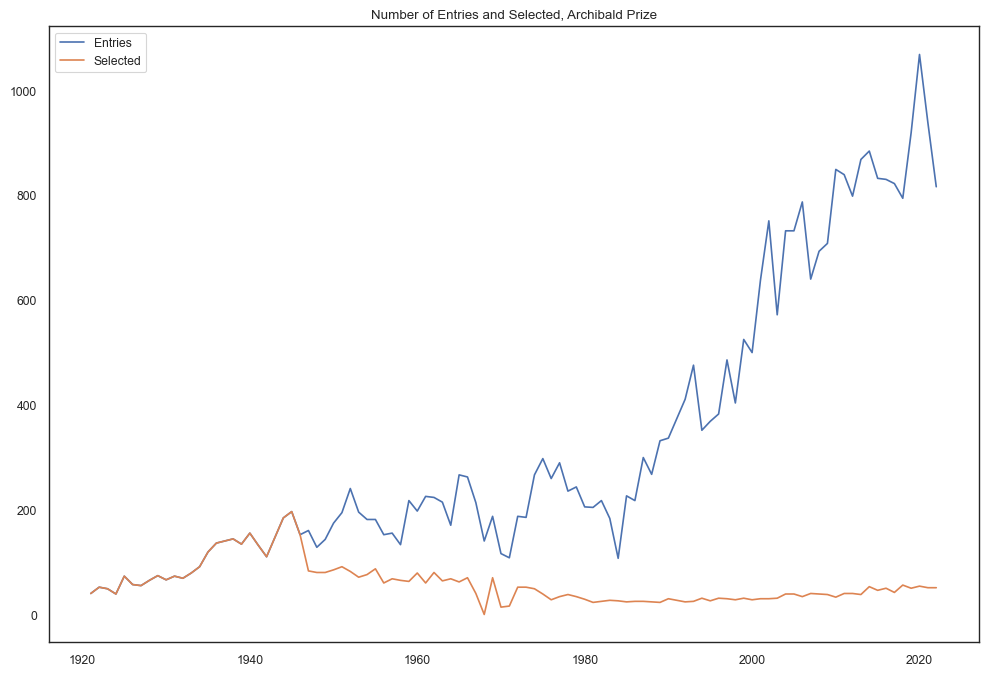

In [18]:
year = []
no_entries = []
no_selected = []

# fetch data from github
archies_dict = fetch_small_data_from_github("archies.csv")

for idx,x in enumerate(archies_dict['Prize Data']):
    year.append(archies_dict['Year'][idx])
    x = ast.literal_eval(x)

    if 'works' in x['Entries']: 
        no_entries.append(int(x['Entries'].split('works')[0].split(' ')[-2]))
        no_selected.append(no_entries[-1])
    elif 'entries' in x['Entries']: 
        no_entries.append(int(x['Entries'].split('entries')[0].split(' ')[-2]))
        no_selected.append(no_entries[-1])
    elif x['Entries'].split(' ')[-1] == 'selected)':
            entr = x['Entries'].split(')')[0]
            this_entr = entr.split('over ')[-1].split(' ')[0]
            no_entries.append(int(this_entr))
            
            this_sel = x['Entries'].split(' ')[1].replace('(','')
            if this_sel == 'one': this_sel = 1
            if 'over' in entr: this_sel = x['Entries'].split(' ')[2].replace('(','')
            no_selected.append(int(this_sel))
            
    else:
        this_entr = x['Entries'].split(' ')[0]
        no_entries.append(int(this_entr))
        
        this_sel = x['Entries'].split(' ')[1].replace('(','')
        no_selected.append(int(this_sel))

no_participants = pd.DataFrame([no_entries,no_selected, year]).T
no_participants.columns = ['Entries','Selected','Year']
no_participants['Year'] = no_participants.Year.astype(int)

fig = plt.figure(figsize=(12, 8))
ax = plt.axes()

ax.plot(no_participants.sort_values('Year')['Year'],
       no_participants.sort_values('Year')['Entries'], label="Entries")

ax.plot(no_participants.sort_values('Year')['Year'],
       no_participants.sort_values('Year')['Selected'], label="Selected")

plt.title('Number of Entries and Selected, Archibald Prize')
plt.legend()
plt.show()

#### Prize Money

It should be noted that we imported the prize money data from the ACDE Github repository. The data was originally sourced from financial reports of the Art Gallery of NSW. Temporal information of sponsors can be found across the AGNSW website for each respective Archibald prize.

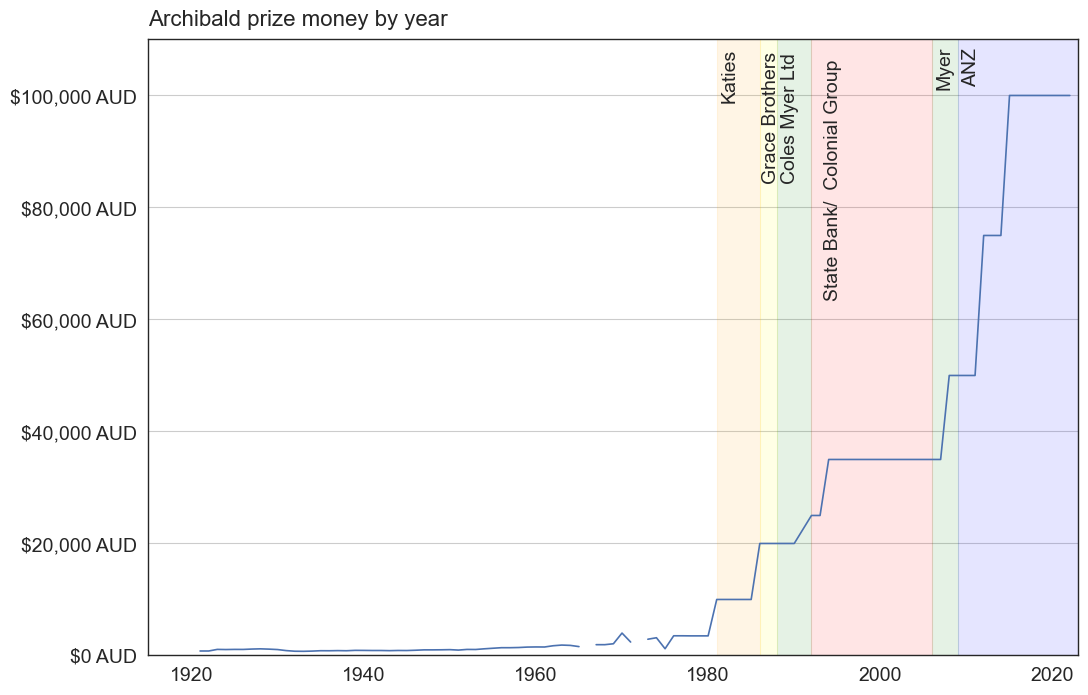

In [30]:
# fetch data from github
prize_money = fetch_small_data_from_github("archies_prizemoney.csv")
prize_money.set_index('Year', inplace=True)

plt.figure(figsize=(12, 8))

# Set the x-axis to the year column
x = prize_money.index

# Set the y-axis to the value column
y = prize_money['AUD_Equivalent']

# Create a line plot of the data
plt.plot(x, y)

# Add labels and a title
plt.xlabel('')
plt.title('Archibald prize money by year', size=16, pad=10, loc='left')

plt.axvspan(1981, 1986, alpha=0.1, color='orange')
plt.text(1982.5, 103500, 'Katies', ha='center', va='center',size=14, rotation=90)

plt.axvspan(1986, 1988, alpha=0.1, color='yellow')
plt.text(1987.25, 96000, 'Grace Brothers', ha='center', va='center',size=14, rotation=90)

plt.axvspan(1988, 1992, alpha=0.1, color='green')
plt.text(1989.5, 96000, 'Coles Myer Ltd', ha='center', va='center',size=14, rotation=90)

plt.axvspan(1992, 2006, alpha=0.1, color='red')
plt.text(1994.5, 85000, 'State Bank/  Colonial Group', ha='center', va='center',
         size=14, rotation=90)

plt.axvspan(2006, 2009, alpha=0.1, color='green')
plt.text(2007.5, 105000, 'Myer', ha='center', va='center',size=14,rotation=90)

plt.axvspan(2009, 2023, alpha=0.1, color='blue')
plt.text(2010.5, 105000, 'ANZ', ha='center', va='center',size=14,rotation=90)

# Format the y-axis labels as a monetary amount
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f} AUD'))

plt.yticks(size=14)
plt.xticks(size=14)

plt.ylim(0,110000)
plt.xlim(1915,2023)

plt.grid(axis='y')

# # save figure
# plt.savefig('prize_money.png', dpi=330, bbox_inches='tight')

# Show the plot
plt.show()

#### Prize money before sponsors

The visuals below show the prize money before sponsors are taken into account. The prize money was originally in pounds, but we have converted it to Australian dollars for ease of interpretation.

We compute the correlation between the number of entries and the change in prize money. We find that the correlation is 0.51, which is a moderate positive correlation. This suggests that the number of entries is positively associated with the change in prize money.

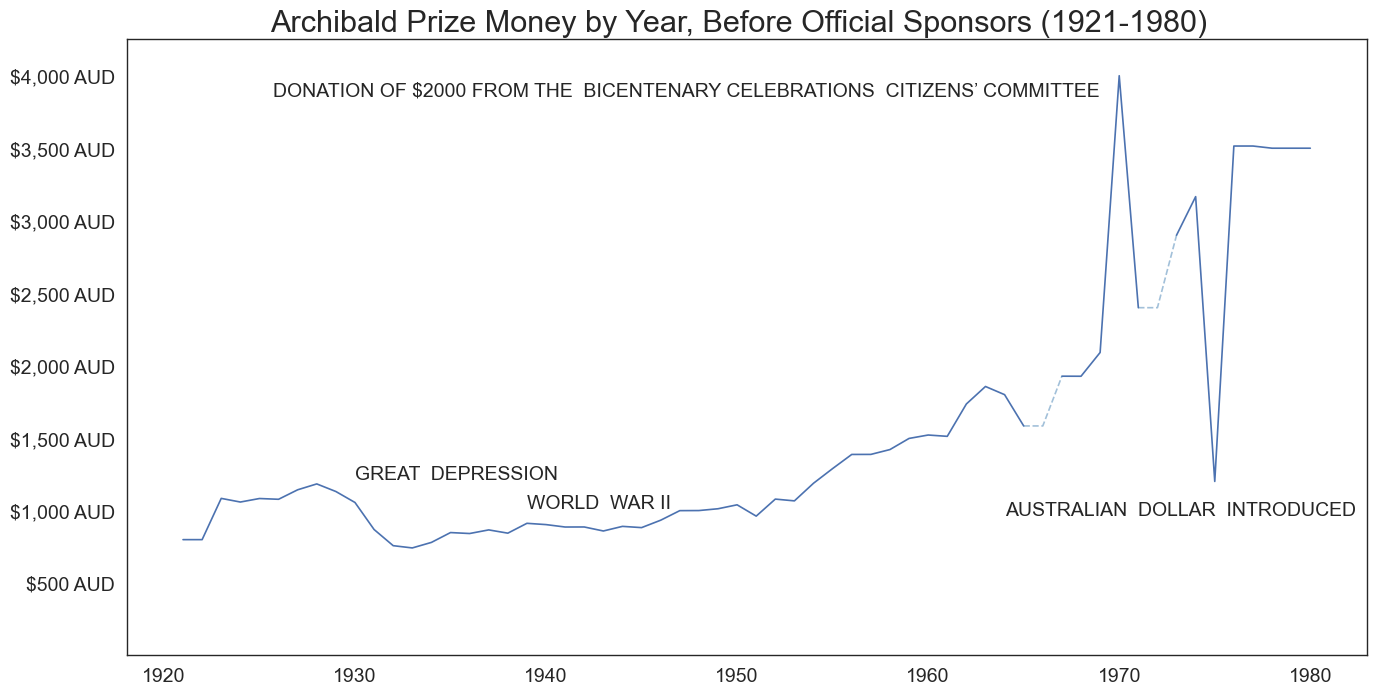

In [20]:
plt.figure(figsize=(16, 8))

missing_cond = (prize_money.index > 1964) & (prize_money.index < 1968)
missing_cond2 = (prize_money.index > 1970) & (prize_money.index < 1974)

# Set the x-axis to the year column
x = prize_money[prize_money.index < 1981].index
x2 = prize_money[missing_cond].index
x3 = prize_money[missing_cond2].index

# Set the y-axis to the value column
y = prize_money[prize_money.index < 1981]['AUD_Equivalent']
y2 = prize_money[missing_cond]['AUD_Equivalent'].ffill()
y3 = prize_money[missing_cond2]['AUD_Equivalent'].ffill()

# Create a line plot of the data
plt.plot(x, y)
plt.plot(x2, y2, linestyle='dashed',color='steelblue',alpha=0.5)
plt.plot(x3, y3, linestyle='dashed',color='steelblue',alpha=0.5)

# Add labels and a title
plt.xlabel('')
plt.title('Archibald Prize Money by Year, Before Official Sponsors (1921-1980)  ', size=22)

# Format the y-axis labels as a monetary amount
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f} AUD'))

plt.text(1930, 1250, 'GREAT  DEPRESSION', ha='left', va='center',size=14)
plt.text(1939, 1050, 'WORLD  WAR II', ha='left', va='center',size=14)
plt.text(1964, 1005, 'AUSTRALIAN  DOLLAR  INTRODUCED', ha='left', va='center',size=14)
plt.text(1969, 3900, 'DONATION OF $2000 FROM THE  BICENTENARY CELEBRATIONS  CITIZENS’ COMMITTEE', ha='right', va='center',size=14)

plt.yticks(size=14)
plt.xticks(size=14)

plt.ylim(1,4250)

# Show the plot
plt.show()

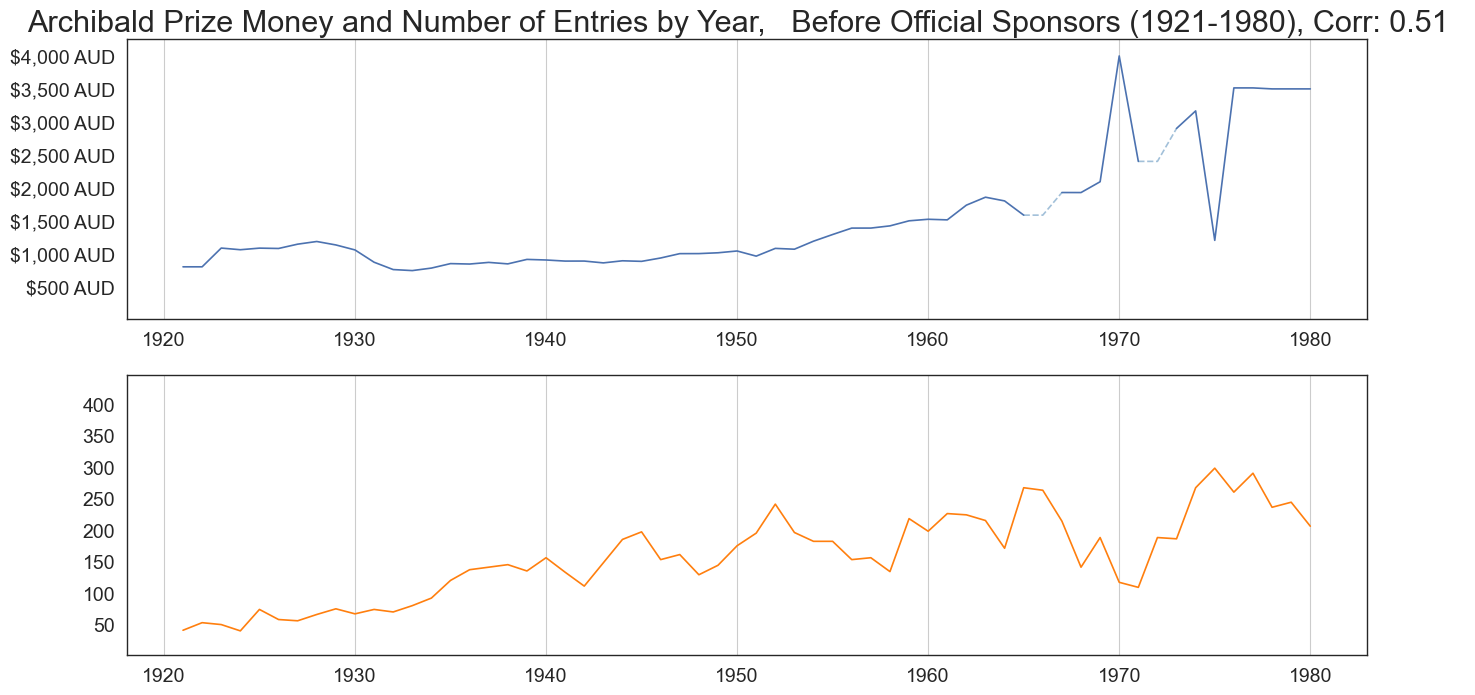

In [21]:
plt.figure(figsize=(16, 8))

missing_cond = (prize_money.index > 1964) & (prize_money.index < 1968)
missing_cond2 = (prize_money.index > 1970) & (prize_money.index < 1974)

# Set the x-axis to the year column
x = prize_money[prize_money.index < 1981].index
x2 = prize_money[missing_cond].index
x3 = prize_money[missing_cond2].index
x4 = no_participants[no_participants.Year < 1981]['Year']

# Set the y-axis to the value column
y = prize_money[prize_money.index < 1981]['AUD_Equivalent']
y2 = prize_money[missing_cond]['AUD_Equivalent'].ffill()
y3 = prize_money[missing_cond2]['AUD_Equivalent'].ffill()
y4 = no_participants[no_participants.Year < 1981]['Entries']

ax = plt.subplot(2, 1, 1)
# Create a line plot of the data
ax.plot(x, y)
ax.plot(x2, y2, linestyle='dashed',color='steelblue',alpha=0.5)
ax.plot(x3, y3, linestyle='dashed',color='steelblue',alpha=0.5)

beforesponsors = pd.merge(no_participants[no_participants.Year < 1981], 
                          prize_money[prize_money.index < 1981].reset_index())

cor = beforesponsors['Entries'].corr(beforesponsors['AUD_Equivalent']).round(2)

# Add labels and a title
plt.xlabel('')
plt.title(f'Archibald Prize Money and Number of Entries by Year,   Before Official Sponsors (1921-1980), Corr: {cor}  ', size=22)

# Format the y-axis labels as a monetary amount
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f} AUD'))

plt.yticks(size=14)
plt.xticks(size=14)
plt.ylim(1,4250)
plt.grid(axis='x')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(x4, y4, color = 'tab:orange')

plt.yticks(size=14)
plt.xticks(size=14)
plt.ylim(1,445)
plt.grid(axis='x')

# Show the plot
plt.show()

#### Prize money with sponsors (post-1980)

The visuals below show the prize money after sponsors are taken into account. There have been six sponsors/partners since 1980.

We compute the correlation between the number of entries and the change in prize money during this period. We find that the correlation is 0.84, which is a strong positive correlation. In contrast to the pre-sponsor period, the correlation is much stronger, which suggests that the number of entries is more strongly associated with the change in prize money during this period.

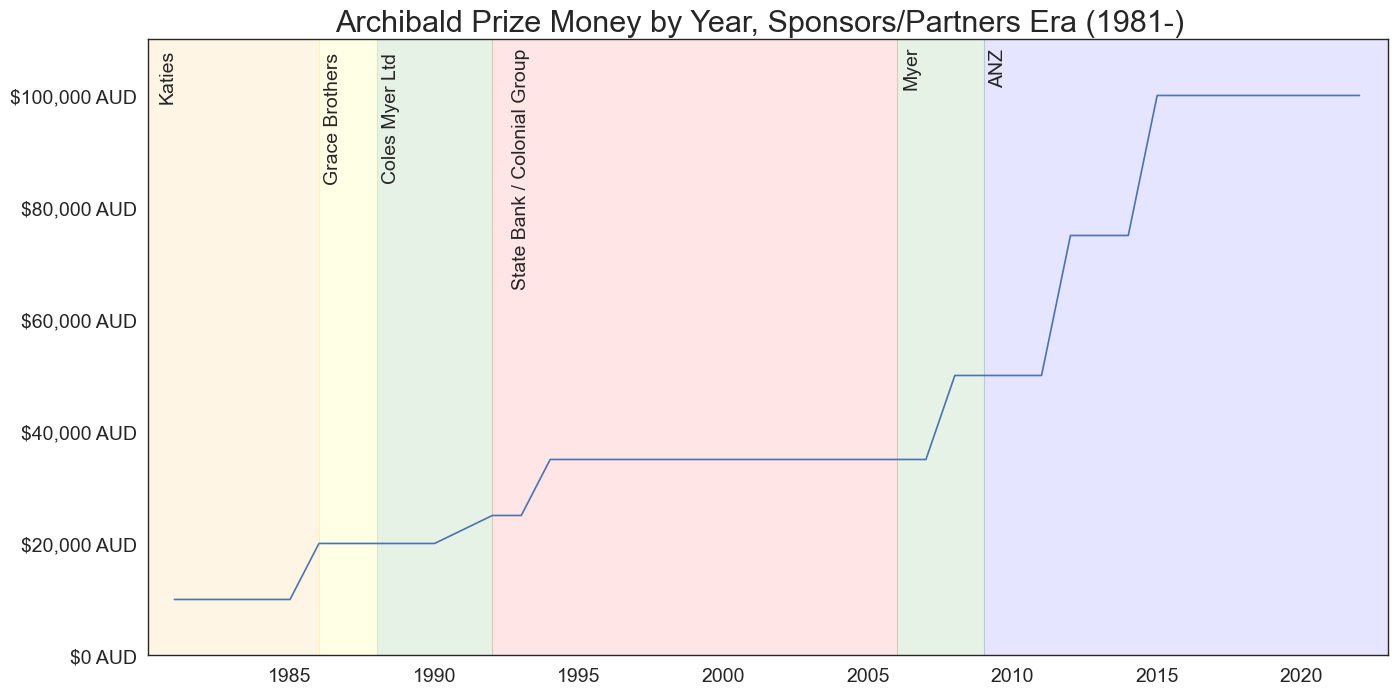

In [22]:
plt.figure(figsize=(16, 8))

# Set the x-axis to the year column
x = prize_money[prize_money.index >= 1981].index
# Set the y-axis to the value column
y = prize_money[prize_money.index >= 1981]['AUD_Equivalent']

# Create a line plot of the data
plt.plot(x, y)

# Add labels and a title
plt.xlabel('')
plt.title('Archibald Prize Money by Year, Sponsors/Partners Era (1981-)  ', size=22)

plt.axvspan(1980, 1986, alpha=0.1, color='orange')
plt.text(1980.75, 103500, 'Katies', ha='center', va='center',size=14, rotation=90)

plt.axvspan(1986, 1988, alpha=0.1, color='yellow')
plt.text(1986.5, 96000, 'Grace Brothers', ha='center', va='center',size=14, rotation=90)

plt.axvspan(1988, 1992, alpha=0.1, color='green')
plt.text(1988.5, 96000, 'Coles Myer Ltd', ha='center', va='center',size=14, rotation=90)

plt.axvspan(1992, 2006, alpha=0.1, color='red')
plt.text(1993, 87000, 'State Bank / Colonial Group', ha='center', va='center',
         size=14, rotation=90)

plt.axvspan(2006, 2009, alpha=0.1, color='green')
plt.text(2006.5, 105000, 'Myer', ha='center', va='center',size=14,rotation=90)

plt.axvspan(2009, 2023, alpha=0.1, color='blue')
plt.text(2009.5, 105000, 'ANZ', ha='center', va='center',size=14,rotation=90)

# Format the y-axis labels as a monetary amount
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f} AUD'))

plt.yticks(size=14)
plt.xticks(size=14)

plt.ylim(0,110000)
plt.xlim(1980.1,2023)

# Show the plot
plt.show()

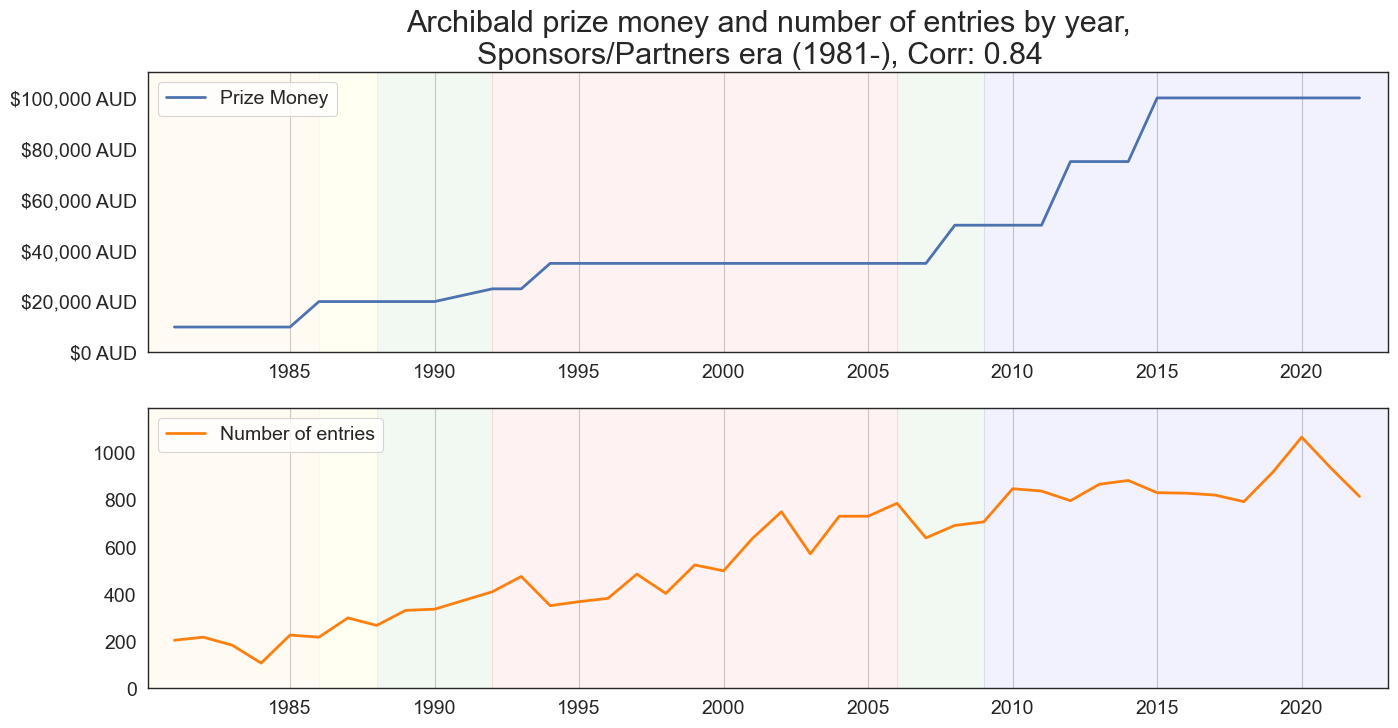

In [23]:
plt.figure(figsize=(16, 8))

# Set the x-axis to the year column
x = prize_money[prize_money.index >= 1981].index
x2 = no_participants[no_participants.Year >= 1981]['Year']

# Set the y-axis to the value column
y = prize_money[prize_money.index >= 1981]['AUD_Equivalent']
y2 = no_participants[no_participants.Year >= 1981]['Entries']


# Create a line plot of the data
ax = plt.subplot(2, 1, 1)
ax.plot(x, y, lw= 2, label='Prize Money')

plt.axvspan(1980, 1986, alpha=0.05, color='orange')
plt.axvspan(1986, 1988, alpha=0.05, color='yellow')
plt.axvspan(1988, 1992, alpha=0.05, color='green')
plt.axvspan(1992, 2006, alpha=0.05, color='red')
plt.axvspan(2006, 2009, alpha=0.05, color='green')
plt.axvspan(2009, 2023, alpha=0.05, color='blue')

# Format the y-axis labels as a monetary amount
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f} AUD'))

plt.yticks(size=14)
plt.xticks(size=14)

plt.ylim(0,110000)
plt.xlim(1980.1,2023)

beforesponsors = pd.merge(no_participants[no_participants.Year >= 1981], 
                          prize_money[prize_money.index >= 1981].reset_index())

cor = beforesponsors['Entries'].corr(beforesponsors['AUD_Equivalent']).round(2)

# Add labels and a title
plt.xlabel('')
plt.title(f'Archibald prize money and number of entries by year,\nSponsors/Partners era (1981-), Corr: {cor}  ', size=22)

# Format the y-axis labels as a monetary amount
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f} AUD'))

plt.yticks(size=14)
plt.xticks(size=14)
plt.grid(axis='x')

# add y-axis label, change angle
plt.legend(title='', loc='upper left', fontsize=14)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(x2, y2, color = 'tab:orange', lw= 2, label='Number of entries')

plt.axvspan(1980, 1986, alpha=0.05, color='orange')
plt.axvspan(1986, 1988, alpha=0.05, color='yellow')
plt.axvspan(1988, 1992, alpha=0.05, color='green')
plt.axvspan(1992, 2006, alpha=0.05, color='red')
plt.axvspan(2006, 2009, alpha=0.05, color='green')
plt.axvspan(2009, 2023, alpha=0.05, color='blue')

plt.yticks(size=14)
plt.xticks(size=14)
plt.ylim(0,1190)
plt.grid(axis='x')

plt.xlim(1980.1,2023)

# add y-axis label, change angle
plt.legend(title='', loc='upper left', fontsize=14)

# save figure
# plt.savefig('correlation.png', dpi=330, bbox_inches='tight')

# Show the plot
plt.show()

#### Participant characteristics

Below we output some summary statistics of the Archibald participant data. the main findings are listed below:

- There are 62 distinct winners of the Archibald prize.
- On average, winning painters begin participating in the Archibald prize at the age of 35 years and stop participating at the age of 61 years.
- While most winning painters participate in the Archibald prize for roughly 10 to 30 years, there are some outliers who participate for much longer. For example, Joshua Smith participated for 64 years, with his first entry at the age of 19 and last entry at the age of 81. 

In [24]:
artist_stats.columns = ['Archibald Winner','Age at first participation', 
                        'Age at last participation','Diff. between first and last']

# Archibald start age
display(pd.DataFrame(artist_stats['Age at first participation'].describe()).T)

# Archibald end age
display(pd.DataFrame(artist_stats['Age at last participation'].describe()).T)

# Archibald overall participation duration
display(pd.DataFrame(artist_stats['Diff. between first and last'].describe()).T)

count       mean        std   min   25%   50%  \
Age at first participation   62.0  38.032258  10.850652  19.0  31.0  35.0   

                             75%   max  
Age at first participation  45.0  64.0

count       mean        std   min   25%   50%  \
Age at last participation   62.0  59.032258  13.047163  33.0  48.0  61.0   

                             75%   max  
Age at last participation  68.75  81.0

count  mean        std  min  25%   50%    75%  \
Diff. between first and last   62.0  21.0  14.990708  0.0  9.5  16.5  31.75   

                               max  
Diff. between first and last  62.0

#### Archibald Prize participation trajectory

We visualise the participation trajectory of winners by illustrating a painter's association with the Archibald over time, where time is reflected by their age. This allows us to compare the participation trajectory of winners normalised by age.

We order the winners by their age at their first win and highlight this first win by a dashed red line. In terms of the y-axis, `Participation` represents an Archibald participation (with no win) and `Win` represents an Archibald win. In other words, high peaks represent Archibald wins and low peaks represent Archibald participations (with no win). This representation allows us to see how often each artist participated in the Archibald prize. In most cases, this occurs in clusters.

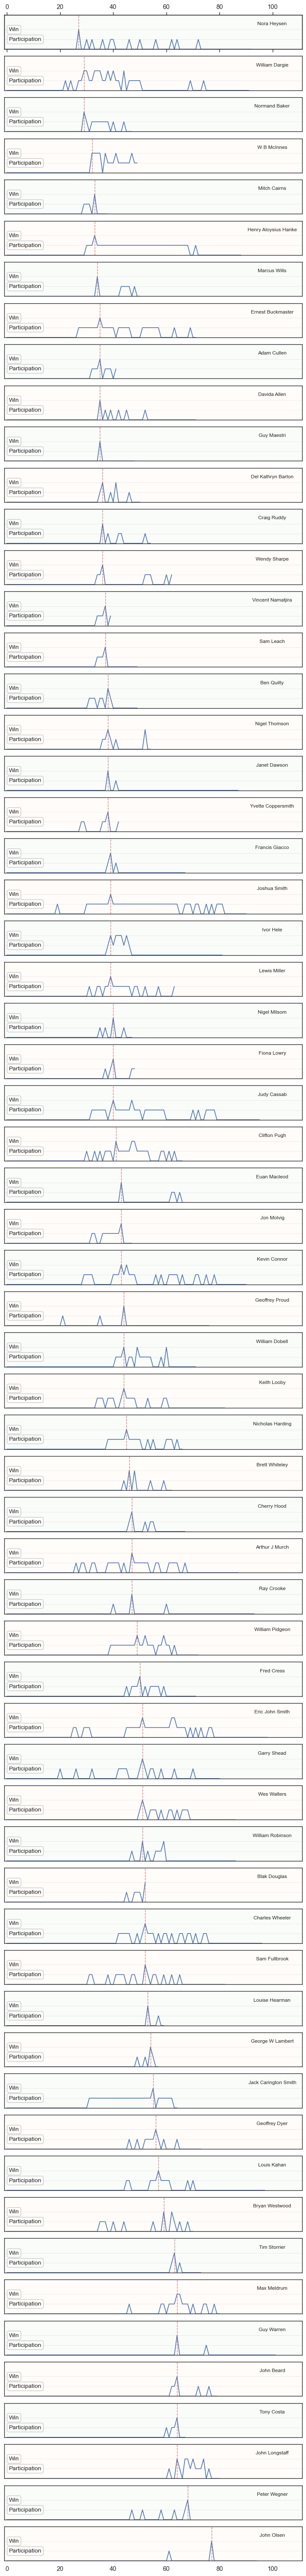

In [25]:
tt = artist_df.T

fig, axes = plt.subplots(tt.shape[1], 1, 
                         figsize=(9, tt.shape[1]*1.25), 
                         sharex=True)

# subtract 1 from every number in dataframe
tt = tt - 1
tt[tt < 0] = 0

# plot each col onto one ax
for idx,(col, ax) in enumerate(zip(tt.columns, axes.flat)):
    colour = 'green'
    
    if idx == 0: ax = ax.twiny()
    if idx % 2: colour = 'orange'
    
    tt[col].plot(ax=ax, rot=0)

    ttt = pd.DataFrame(tt[col])
    markthis = ttt[ttt[col] == 2].index[0]

    # add grid
    ax.axhline(1, color='grey', linestyle='-', lw=0.5, alpha=0.2)
    ax.axhline(2, color='grey', linestyle='-', lw=0.5, alpha=0.2)
    
    ax.axvline(markthis, color='r', linestyle='--', lw=1, alpha=0.7)
    ax.set_title(col, x=0.9, y=0.6, size=8.5)
    ax.set_ylim(0,3.5)
    ax.set_xlim(-1,111)
    ax.axvspan(-1, 111, alpha=0.025, color=colour)
    
   # add annotation for y-axis ticks
    ax.annotate('Participation', xy=(0.75, 1), ha='left', va='center', size=10,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='grey', alpha=0.5))
    ax.annotate('Win', xy=(0.75, 2), ha='left', va='center', size=10,
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='grey', alpha=0.5))

    # remove y-axis
    ax.set_yticks([])

    # make x-ticks larger
    ax.tick_params(axis='x', labelsize=10.5)

# # save figure
# plt.savefig('images/images_analysis/archies_trajectories.png', dpi=330, bbox_inches='tight')
plt.show()


We also considered used a sankey diagram to visualise trajectories, however more efforts are needed to make the visual easier to interpret.

<br>

<img src="images/images_analysis/archies_test_sankey.png" alt="Archibald Sankey" class="bg-secondary" width="850px">

## Who is in the portrait?

We investigate sitter characteristics of winning portraits such as their occupation and/or relationship with painter. We use the ANZSCO classification system to categorise the occupation of the sitter. The ANZSCO classification system is a skill-based classification system used to classify all occupations and jobs in the Australian and New Zealand labour markets.

Below we see the proportions of winning portraits by sitter occupation. The most common occupation is Arts and Media Professionals (58%).

In [26]:
archies['ANZSCO_1'].fillna('Uncategorised', inplace=True)
display(archies['ANZSCO_1'].value_counts(normalize=True))

Arts and Media Professionals                                0.578431
Chief Executives, General Managers and Legislators          0.127451
Uncategorised                                               0.107843
Design, Engineering, Science and Transport Professionals    0.039216
Education Professionals                                     0.029412
Health Professionals                                        0.029412
Legal, Social and Welfare Professionals                     0.029412
Protective Service Workers                                  0.019608
Sports and Personal Service Workers                         0.019608
Hospitality, Retail and Service Managers                    0.019608
Name: ANZSCO_1, dtype: float64

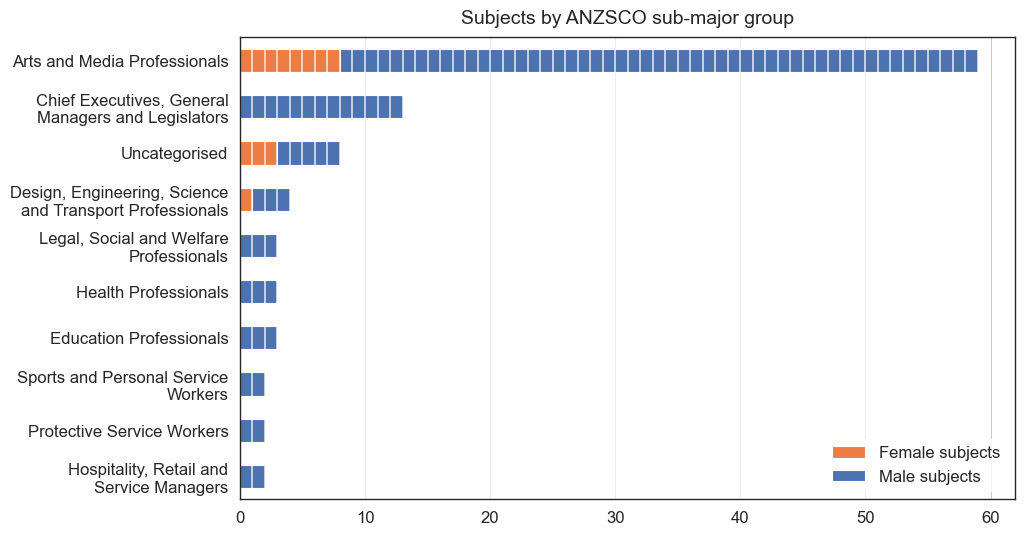

In [27]:
archies['Decade'] = [ int(np.floor(int(year)/10) * 10) 
                       for year in np.array(archies["YEAR"])]

t1 = pd.crosstab([ '\n'.join(wrap(line, 30)) for line in archies['ANZSCO_1']], # breaks strings into new lines
                 archies['GENDER'])
t1['total'] = t1['Female'] + t1['Male']
t1.columns = ['Female subjects', 'Male subjects', 'total']

# plot horizontal stacvked bar chart
t1.sort_values('total').drop('total',axis=1).plot.barh(stacked=True, figsize=(10, 6), color=['#EC7E45', '#4C72B0'])

# remove y=axis title
plt.ylabel('')

# increase y-axis tick size
plt.yticks(size=12)
plt.xticks(size=12)

# add vertical lines to show the 50% mark
for x in range(1,60,1):
    plt.axvline(x, color='white', linestyle='-', lw=1.25, alpha=0.75)

plt.legend(ncol=1, title='', fontsize=12, title_fontsize=10, loc='lower right', facecolor='white', edgecolor='white')

plt.title('Subjects by ANZSCO sub-major group', size=14, pad=10)

# add gird lines
plt.grid(axis='x')

# save figure
# plt.savefig('subject_by_anzsco.png', dpi=330, bbox_inches='tight')

plt.show()

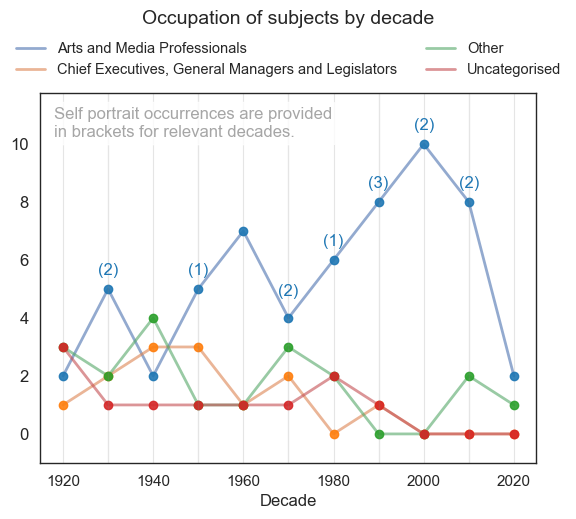

In [28]:
archies['Decade'] = [ int(np.floor(int(year)/10) * 10) 
                       for year in np.array(archies["YEAR"])]

archies['ANZSCO_1'].fillna('Family/Friend', inplace=True)
archies['ANZSCO_1_v2'] = np.where(archies['ANZSCO_1'].isin(['Arts and Media Professionals',
                                                            'Chief Executives, General Managers and Legislators',
                                                            'Uncategorised']),archies['ANZSCO_1'],'Other')
t1 = pd.crosstab(archies['Decade'],archies['ANZSCO_1_v2'])

ax = t1.plot(linewidth=2, alpha=0.6)
plt.legend(ncol=4, bbox_to_anchor=(1, 1.1))
t1.plot(marker="o", markersize=6, alpha=0.9, ax=ax, linewidth=0, color=['#1f77b4','#ff7f0e','#2ca02c','#d62728'], legend=None)

# remove items from legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:4], labels=labels[:4], ncol=2, bbox_to_anchor=(0.5, 1.175), 
          fontsize=10.5, loc='upper center', frameon=False)

# add grid lines for every 10 years
plt.grid(axis='x', alpha=0.5)

# add vertical lines for every 10 years
plt.axvline(1930, color='grey', linestyle='-', lw=1, alpha=0.2)
plt.axvline(1950, color='grey', linestyle='-', lw=1, alpha=0.2)
plt.axvline(1970, color='grey', linestyle='-', lw=1, alpha=0.2)
plt.axvline(1990, color='grey', linestyle='-', lw=1, alpha=0.2)
plt.axvline(2010, color='grey', linestyle='-', lw=1, alpha=0.2)

plt.title('Occupation of subjects by decade\n', size=14, pad=35)

# increae y-axis tick size
plt.yticks(size=12)
plt.xticks(size=11)

# increase x-axis title size
plt.xlabel('Decade', size=12)

# add annotations to the plot
plt.annotate('(2)', xy=(1930, 1), xytext=(1930, 5.5), size=12, color='tab:blue', ha='center')
plt.annotate('(1)', xy=(1950, 1), xytext=(1950, 5.5), size=12, color='tab:blue', ha='center')
plt.annotate('(2)', xy=(1970, 1), xytext=(1970, 4.75), size=12, color='tab:blue', ha='center')
plt.annotate('(1)', xy=(1980, 1), xytext=(1980, 6.5), size=12, color='tab:blue', ha='center')
plt.annotate('(3)', xy=(1990, 1), xytext=(1990, 8.5), size=12, color='tab:blue', ha='center')
plt.annotate('(2)', xy=(2000, 1), xytext=(2000, 10.5), size=12, color='tab:blue', ha='center')
plt.annotate('(2)', xy=(2010, 1), xytext=(2010, 8.5), size=12, color='tab:blue', ha='center')

# add box for annotation
plt.annotate('Self portrait occurrences are provided\nin brackets for relevant decades.', xy=(1918, 1), xytext=(1918, 10.25), 
             size=12, color='grey', ha='left', alpha=0.7, bbox=dict(boxstyle='round', fc='white', ec='white', alpha=0.8))


# increase y-axis
plt.ylim(-1, 11.75)

# plt.savefig('subject_occupation_by_decade.png', dpi=330, bbox_inches='tight')

plt.show()

## Online presence of recent winners

Lastly, we investigate the online presence of recent winners through quantifed measures extracted from **Google Trends** data. Numbers on the y-axis represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means that there was not enough data for this term.

We focus on the five most recent winners.

- 2018: Yvette Coppersmith
- 2019: Tony Costa
- 2020: Vincent Namatjira 
- 2021: Peter Wegner
- 2022: Blak Douglas

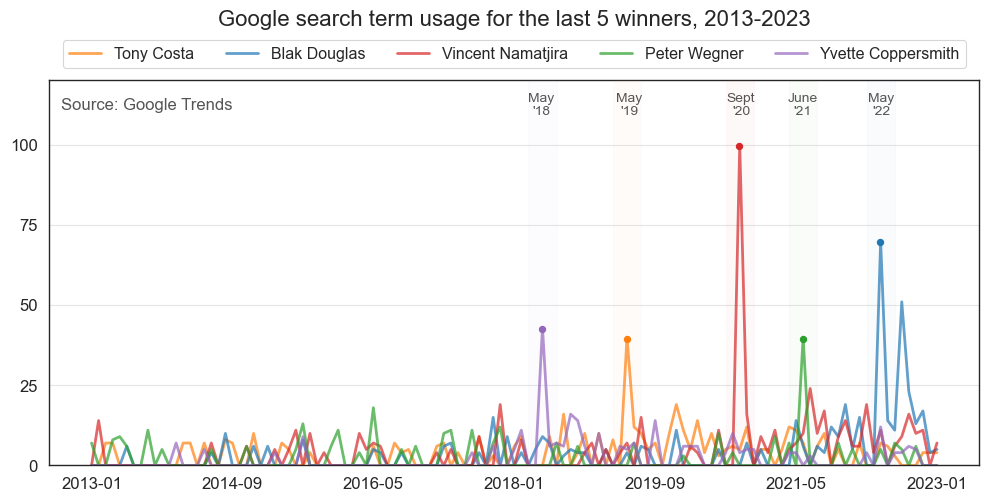

In [29]:
# read data from github
googletrends = fetch_small_data_from_github('archies_Last5winners.csv')

sns.set(style='white', context='paper', rc={'figure.figsize':(12, 5)})

# plot a time series with Interest as the y-axis and x-axis in years
ax = googletrends.plot(x='Month', y='Tony Costa', color='tab:orange', linewidth=2, zorder=1, alpha=0.7)
googletrends.plot(x='Month', y='Blak Douglas', color='tab:blue', linewidth=2, zorder=1, ax=ax, alpha=0.7)
googletrends.plot(x='Month', y='Vincent Namatjira', color='tab:red', linewidth=2, zorder=1, ax=ax, alpha=0.7)
googletrends.plot(x='Month', y='Peter Wegner', color='tab:green', linewidth=2, zorder=1, ax=ax, alpha=0.7)
googletrends.plot(x='Month', y='Yvette Coppersmith', color='tab:purple', linewidth=2, zorder=1, ax=ax, alpha=0.7)

# add point hollow
ax.scatter(googletrends[googletrends['Month'] == '2018-05'].index.values[0],
           googletrends[googletrends['Month'] == '2018-05']['Yvette Coppersmith'].values[0]-.5,
           s=20, color='tab:purple', zorder=2)

ax.scatter(googletrends[googletrends['Month'] == '2019-05'].index.values[0],
           googletrends[googletrends['Month'] == '2019-05']['Tony Costa'].values[0]-.5,
           s=20, color='tab:orange', zorder=2)

ax.scatter(googletrends[googletrends['Month'] == '2020-09'].index.values[0]-.0345,
           googletrends[googletrends['Month'] == '2020-09']['Vincent Namatjira'].values[0]-.5,
           s=20, color='tab:red', zorder=2)

ax.scatter(googletrends[googletrends['Month'] == '2021-06'].index.values[0],
           googletrends[googletrends['Month'] == '2021-06']['Peter Wegner'].values[0]-.5,
           s=20, color='tab:green', zorder=2)

ax.scatter(googletrends[googletrends['Month'] == '2022-05'].index.values[0]-.025,
           googletrends[googletrends['Month'] == '2022-05']['Blak Douglas'].values[0]-.5,
           s=20, color='tab:blue', zorder=2)

# add source annotation in bottom right corner
plt.annotate('Source: Google Trends', xy=(0.0125, .925), xycoords='axes fraction', fontsize=12, color='#555555', zorder=2)

# add source annotation in bottom right corner
plt.annotate("May\n'18", xy=(googletrends[googletrends['Month'] == '2018-05'].index.values[0]/googletrends.shape[0], 0.91), 
             xycoords='axes fraction', fontsize=10, color='#555555', ha='center')

# add source annotation in bottom right corner
plt.annotate("May\n'19", xy=((googletrends[googletrends['Month'] == '2019-05'].index.values[0]-0.5)/googletrends.shape[0], 0.91), 
             xycoords='axes fraction', fontsize=10, color='#555555', ha='center')

# add source annotation in bottom right corner
plt.annotate("Sept\n'20", xy=((googletrends[googletrends['Month'] == '2020-09'].index.values[0]-2)/googletrends.shape[0], 0.91), 
             xycoords='axes fraction', fontsize=10, color='#555555', ha='center')

# add source annotation in bottom right corner
plt.annotate("June\n'21", xy=((googletrends[googletrends['Month'] == '2021-06'].index.values[0]-3)/googletrends.shape[0], 0.91), 
             xycoords='axes fraction', fontsize=10, color='#555555', ha='center')

# add source annotation in bottom right corner
plt.annotate("May\n'22", xy=((googletrends[googletrends['Month'] == '2022-05'].index.values[0]-3.75)/googletrends.shape[0], 0.91), 
             xycoords='axes fraction', fontsize=10, color='#555555', ha='center')

# shade plot for 2018
plt.axvspan(googletrends[googletrends['Month'] == '2018-03'].index.values[0], 
            googletrends[googletrends['Month'] == '2018-07'].index.values[0], 
            color='tab:purple', alpha=0.025, zorder=3)

# shade plot for 2019
plt.axvspan(googletrends[googletrends['Month'] == '2019-03'].index.values[0], 
            googletrends[googletrends['Month'] == '2019-07'].index.values[0], 
            color='tab:orange', alpha=0.025, zorder=3)

# shade plot for 2020
plt.axvspan(googletrends[googletrends['Month'] == '2020-07'].index.values[0], 
            googletrends[googletrends['Month'] == '2020-11'].index.values[0], 
            color='tab:red', alpha=0.025, zorder=3)

# shade plot for 2021
plt.axvspan(googletrends[googletrends['Month'] == '2021-04'].index.values[0], 
            googletrends[googletrends['Month'] == '2021-08'].index.values[0], 
            color='tab:green', alpha=0.025, zorder=3)

# shade plot for 2022
plt.axvspan(googletrends[googletrends['Month'] == '2022-03'].index.values[0], 
            googletrends[googletrends['Month'] == '2022-07'].index.values[0], 
            color='tab:blue', alpha=0.025, zorder=3)

plt.xlabel('')
plt.grid(axis='y', alpha=0.5)
plt.gca().set_axisbelow(True)
plt.yticks(np.arange(0, 110, 25), fontsize=12)
plt.xticks(fontsize=12)

plt.ylim(0, 120)

plt.title('Google search term usage for the last 5 winners, 2013-2023\n\n', fontsize=16)
plt.legend(loc='upper center', fontsize=11.5, bbox_to_anchor=(0.5, 1.125), ncol=5)

# save figure
# plt.savefig('google_trends_last_five_winners.png', dpi=330, bbox_inches='tight')

plt.show()

# Numbers represent search interest relative to the highest point on the chart for the given region and time. 
# A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. 
# A score of 0 means that there was not enough data for this term."